# Q Learning

## Spring mass system
Maximize the mass compression

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\4211845899.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.qpos[0] = qpos_spring  # Start from spring equilibrium
C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\4211845899.py:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action_idx = choose_action(int(spring_deviation))  # Use the spring deviation as the state
C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\4211845899.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your

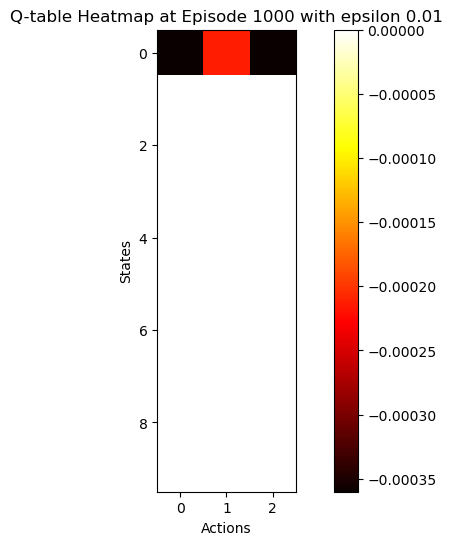

 20%|█▉        | 1992/10000 [00:11<00:36, 220.90it/s]

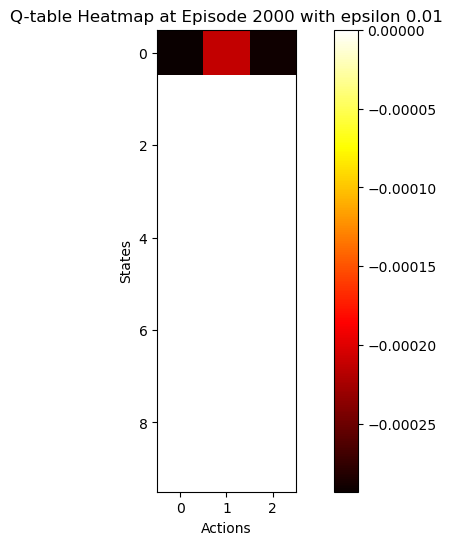

 30%|██▉       | 2985/10000 [00:16<00:33, 206.69it/s]

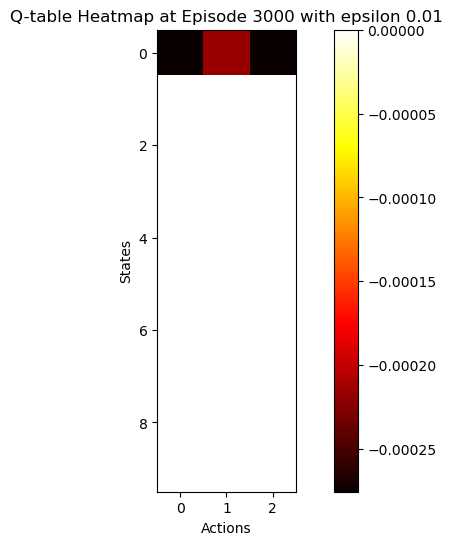

 40%|███▉      | 3984/10000 [00:21<00:31, 193.94it/s]

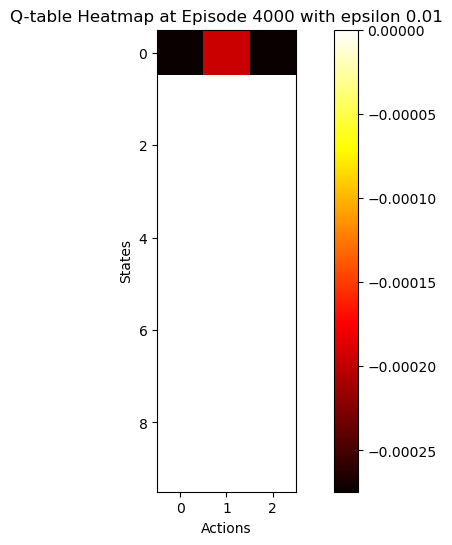

 50%|████▉     | 4983/10000 [00:26<00:22, 221.62it/s]

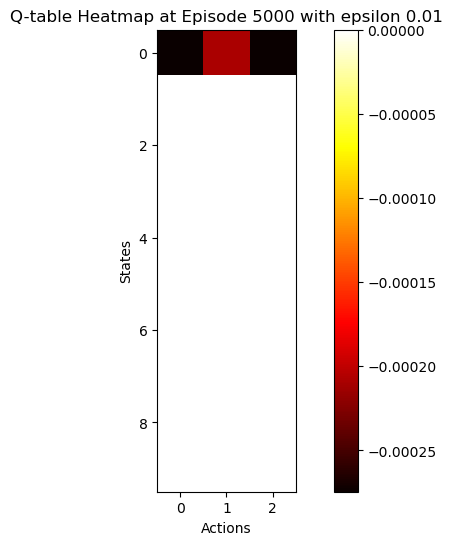

 60%|█████▉    | 5979/10000 [00:31<00:17, 228.76it/s]

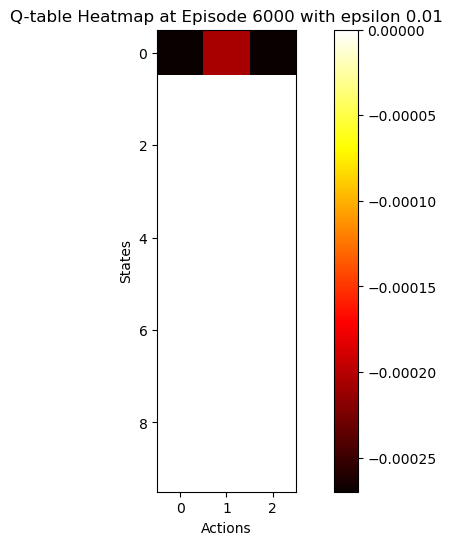

 70%|██████▉   | 6996/10000 [00:35<00:14, 208.32it/s]

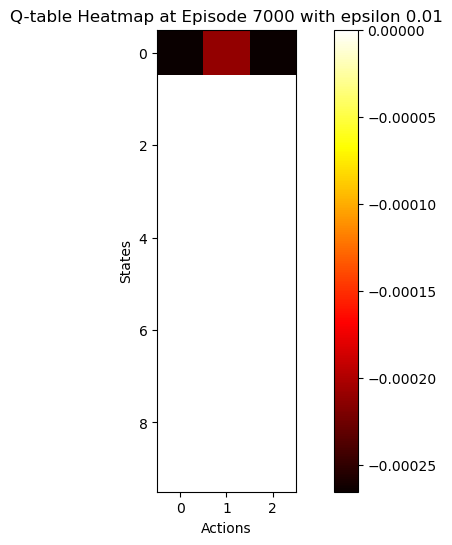

 80%|███████▉  | 7984/10000 [00:40<00:09, 211.38it/s]

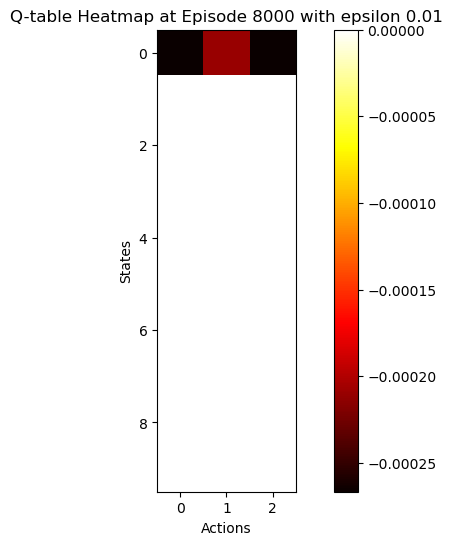

 90%|████████▉ | 8997/10000 [00:45<00:04, 206.40it/s]

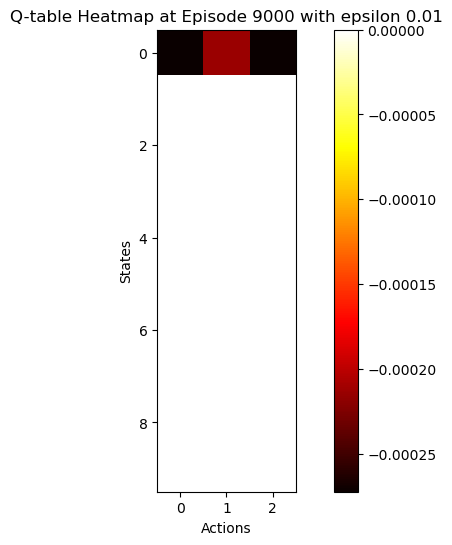

100%|█████████▉| 9984/10000 [00:50<00:00, 200.00it/s]

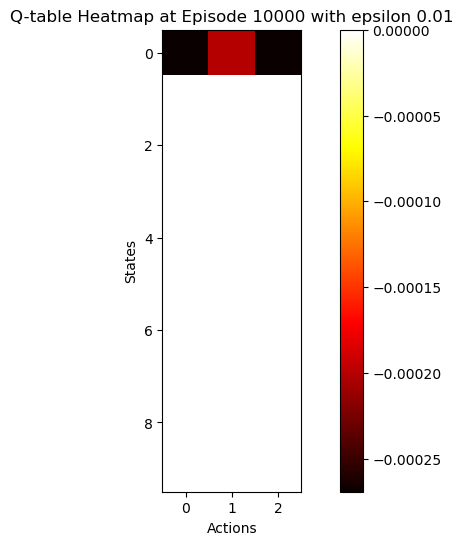

100%|██████████| 10000/10000 [00:53<00:00, 187.60it/s]


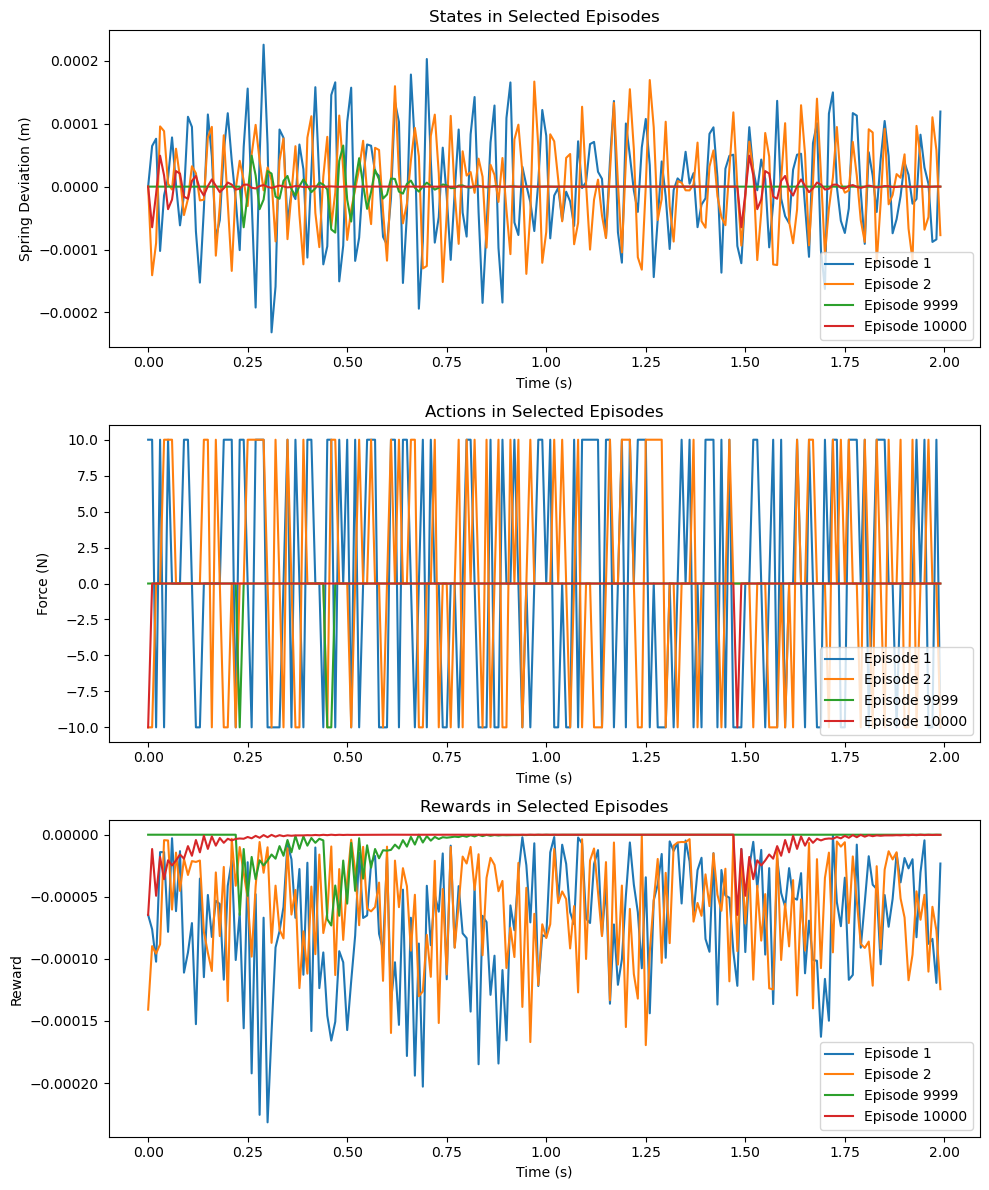

In [7]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import cv2
from tqdm import tqdm
import os

# Constants
EPISODES = 10000
EPISODE_LENGTH = 200
SAMPLE_RATE = 0.01
LEARNING_RATE = 0.002
EPSILON_DECAY = 0.8
MIN_EPSILON = 0.01
GAMMA = 0.99
ACTIONS = [-10, 0, 10]  # Actions in the environment

# Initialize Q-table and epsilon
Q_table = np.zeros((10, len(ACTIONS)))  # 10 states, 3 actions (for simplicity)
EPSILON = 1.0


# Define functions
def choose_action(state):
    """Choose action using epsilon-greedy strategy."""
    if np.random.rand() < EPSILON:
        return np.random.choice(len(ACTIONS))  # Random action
    else:
        return np.argmax(Q_table[state])  # Greedy action

def step_environment(model, data, action, qpos_spring):
    """Step the environment and return next state, reward, done."""
    data.ctrl[0] = action  # Apply force as action
    mujoco.mj_step(model, data)  # Step simulation
    spring_deviation = data.qpos[0] - qpos_spring  # Deviation from equilibrium
    reward = -abs(spring_deviation) # maximize spring compression
    done = False
    return spring_deviation, reward, done

def add_text_to_frame(frame, text, position, font_scale=0.6, color=(0, 0, 0), thickness=2):
    """Helper function to add text to video frames."""
    return cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

def plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live):
    """Plot results."""
    plt.figure(figsize=(10, 12))

    # Plot for state variables
    plt.subplot(3, 1, 1)
    plt.title("States in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Spring Deviation (m)")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("Actions in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, actions_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Force (N)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("Rewards in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, rewards_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Reward")
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    global EPSILON
    task_variable_values = []
    episode_rewards = []
    state_vars = []
    actions_live = []
    rewards_live = []

    # Load model and data
    model_path = os.path.join('..', '..', 'MujocoEnvs', 'springmass.xml')
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)

    # Get the reference equilibrium position for the uncompressed spring
    qpos_spring = model.qpos_spring

    # Initialize rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    renderer = mujoco.Renderer(model)
    camera_name = "cam1"
    requested_episodes = {0, 1, EPISODES - 2, EPISODES - 1}
    video_frames = []

    for episode in tqdm(range(EPISODES)):
        total_rewards_per_step = []  # Store rewards at each step
        data.qpos[0] = qpos_spring  # Start from spring equilibrium
        options = mujoco.MjvOption()
        mujoco.mjv_defaultOption(options)
        episode_state_vars = []
        episode_actions = []
        episode_rewards_timestep = []
        for step in range(EPISODE_LENGTH):
            spring_deviation = data.qpos[0] - qpos_spring
            action_idx = choose_action(int(spring_deviation))  # Use the spring deviation as the state
            action = ACTIONS[action_idx]

            next_spring_deviation, reward, done = step_environment(model, data, action, qpos_spring)
            total_rewards_per_step.append(reward)
            episode_state_vars.append(spring_deviation)
            episode_actions.append(action)
            episode_rewards_timestep.append(reward)

            # Q-learning update
            Q_table[int(spring_deviation), action_idx] += LEARNING_RATE * (reward + GAMMA * np.max(Q_table[int(next_spring_deviation)]) - Q_table[int(spring_deviation), action_idx])

            # Render selected episodes
            if episode in requested_episodes:
                renderer.update_scene(data, camera_name, options)
                pixel = renderer.render()
                frame = cv2.cvtColor(pixel, cv2.COLOR_RGB2BGR)
                frame = add_text_to_frame(frame, f'Episode: {int(episode+1)}', (10, 30))
                frame = add_text_to_frame(frame, f'Time (s): {step * SAMPLE_RATE:.2f}', (10, 60))
                frame = add_text_to_frame(frame, f'Force (N): {action:.2f}', (10, 90))
                video_frames.append(frame)

            if done:
                break

        state_vars.append(episode_state_vars)
        actions_live.append(episode_actions)
        rewards_live.append(episode_rewards_timestep)
        episode_rewards.append(total_rewards_per_step)
        task_variable_values.append(data.qpos[0])  # Store final position of the mass

        # Update epsilon for exploration decay
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

        # Plot Q-table heatmap every 1000 episodes
        if (episode + 1) % 1000 == 0:
            plt.figure(figsize=(10, 6))
            plt.title(f"Q-table Heatmap at Episode {episode + 1} with epsilon {EPSILON:.2f}")
            plt.imshow(Q_table, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()

    # Show the rendered video
    media.show_video(video_frames, fps=100)

    # Plot results for rewards and task variables
    plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live)

if __name__ == "__main__":
    main()


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\4183620103.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.qpos[0] = qpos_spring  # Start from spring equilibrium
C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\4183620103.py:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action_idx = choose_action(int(spring_deviation))  # Use the spring deviation as the state
C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\4183620103.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your

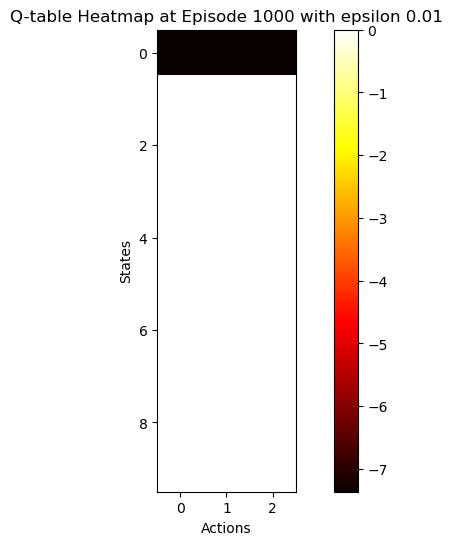

 20%|█▉        | 1998/10000 [00:09<00:28, 279.07it/s]

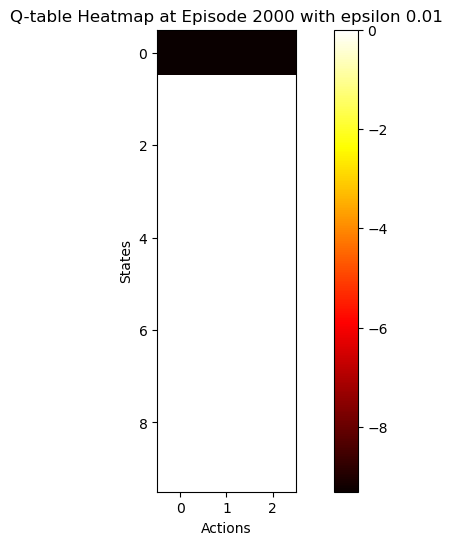

 30%|██▉       | 2987/10000 [00:13<00:24, 281.23it/s]

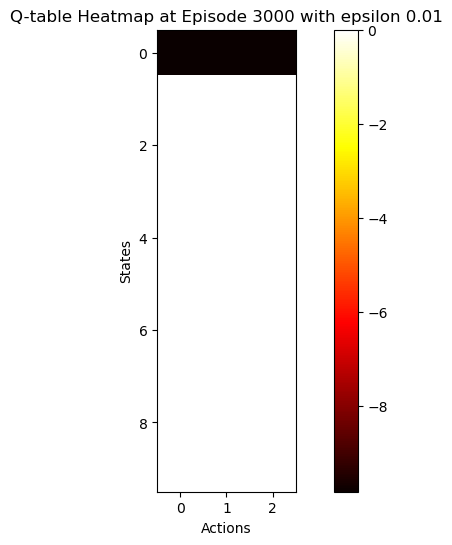

 40%|███▉      | 3980/10000 [00:16<00:19, 304.34it/s]

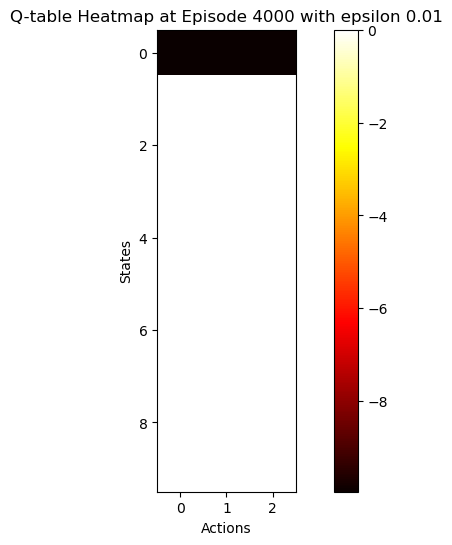

 50%|████▉     | 4992/10000 [00:20<00:16, 299.07it/s]

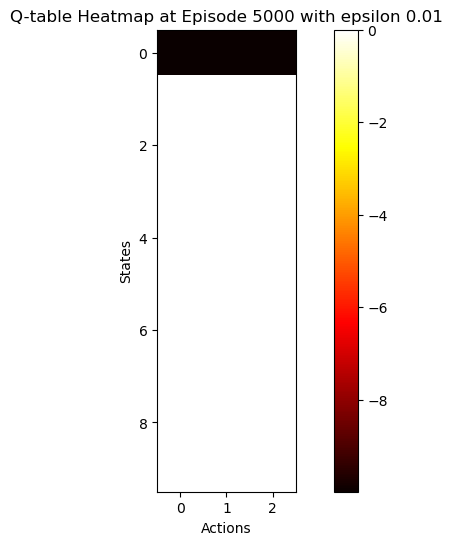

 60%|█████▉    | 5995/10000 [00:23<00:13, 303.06it/s]

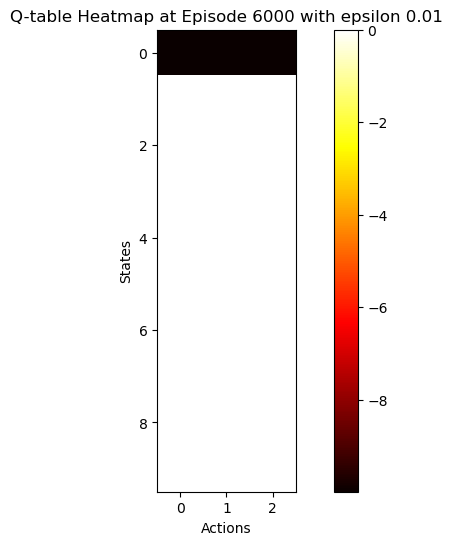

 70%|██████▉   | 6997/10000 [00:26<00:10, 288.71it/s]

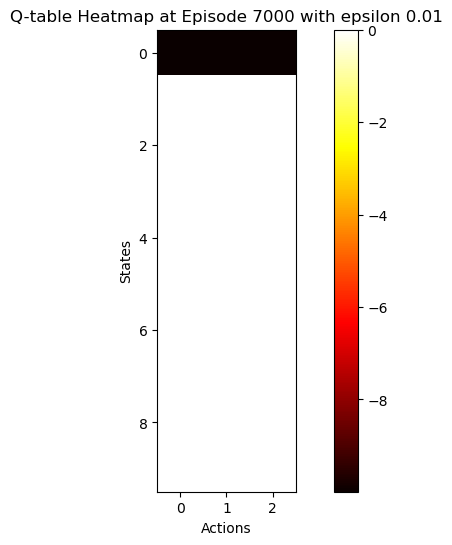

 80%|███████▉  | 7983/10000 [00:30<00:06, 290.60it/s]

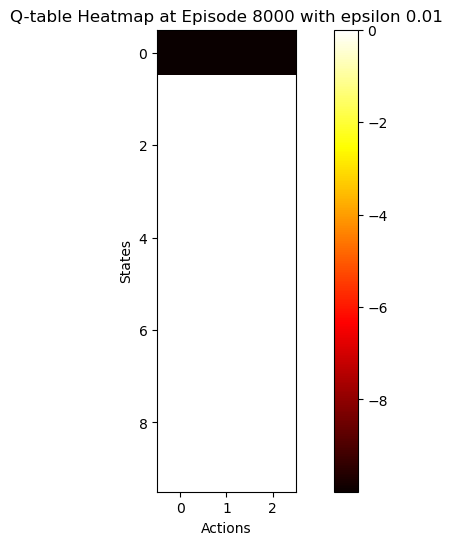

 90%|████████▉ | 8998/10000 [00:33<00:03, 310.63it/s]

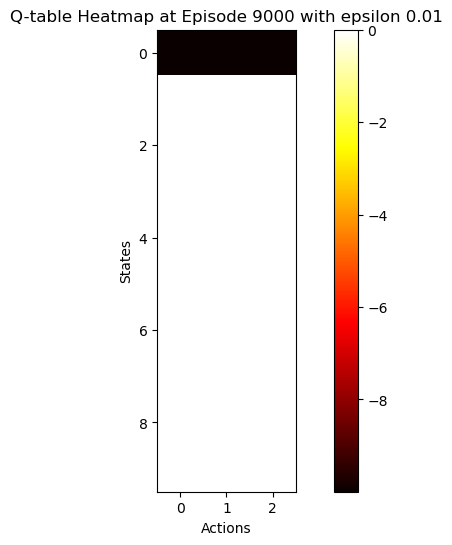

100%|█████████▉| 9983/10000 [00:37<00:00, 299.62it/s]

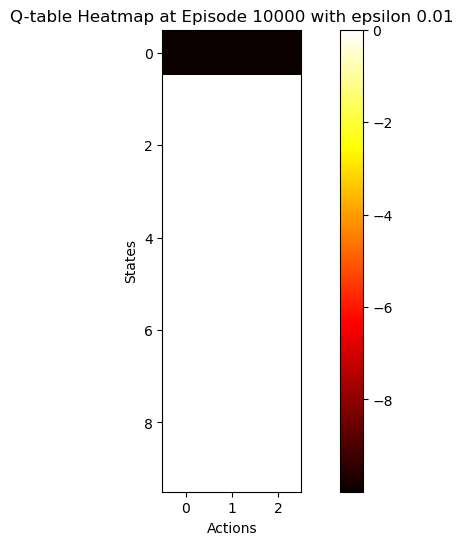

100%|██████████| 10000/10000 [00:39<00:00, 253.69it/s]


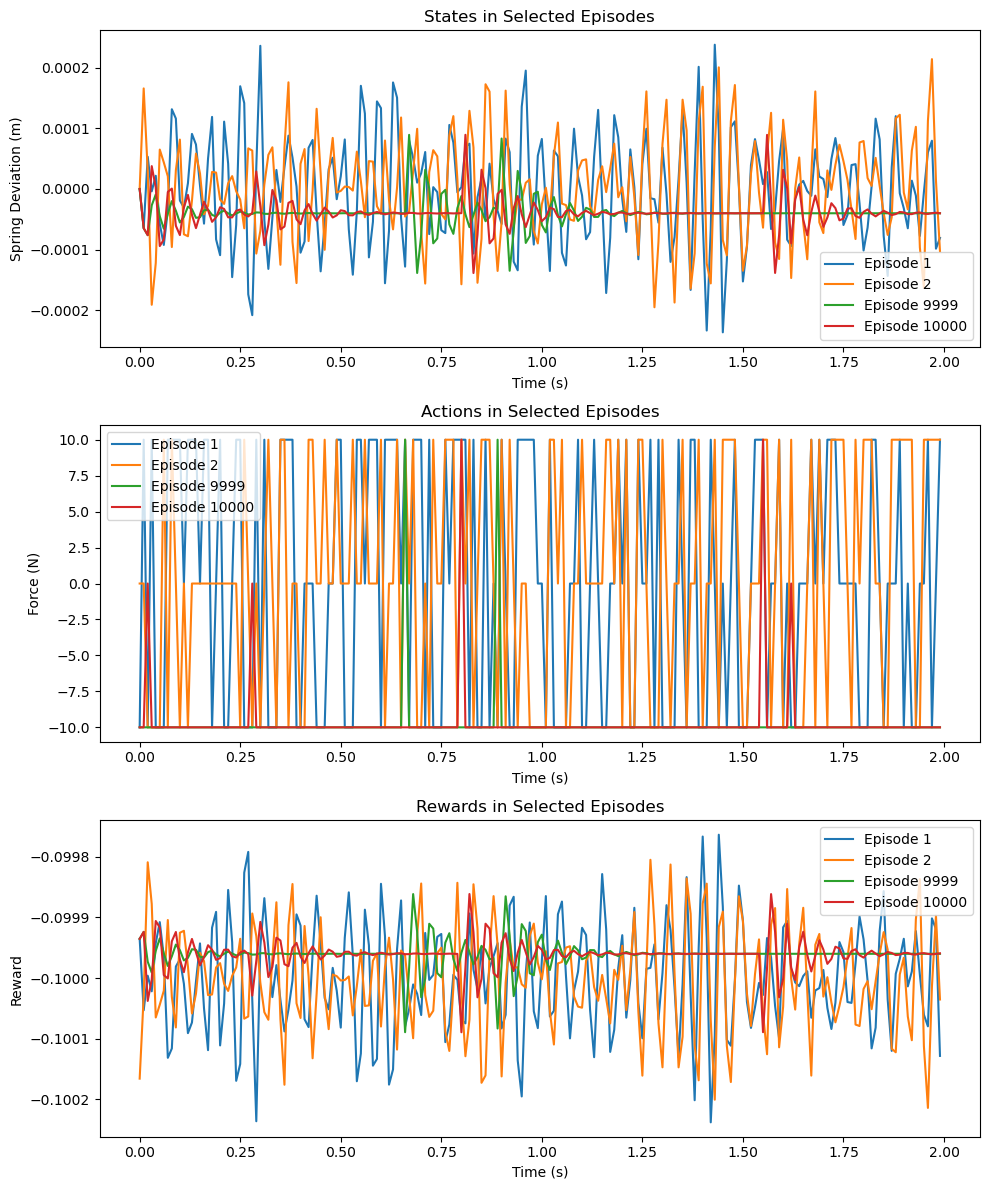

In [8]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import cv2
from tqdm import tqdm
import os

# Constants
EPISODES = 10000
EPISODE_LENGTH = 200
SAMPLE_RATE = 0.01
LEARNING_RATE = 0.002
EPSILON_DECAY = 0.8
MIN_EPSILON = 0.01
GAMMA = 0.99
ACTIONS = [-10, 0, 10]  # Actions in the environment

# Initialize Q-table and epsilon
Q_table = np.zeros((10, len(ACTIONS)))  # 10 states, 3 actions (for simplicity)
EPSILON = 1.0


# Define functions
def choose_action(state):
    """Choose action using epsilon-greedy strategy."""
    if np.random.rand() < EPSILON:
        return np.random.choice(len(ACTIONS))  # Random action
    else:
        return np.argmax(Q_table[state])  # Greedy action

def step_environment(model, data, action, qpos_spring):
    """Step the environment and return next state, reward, done."""
    data.ctrl[0] = action  # Apply force as action
    mujoco.mj_step(model, data)  # Step simulation
    spring_deviation = data.qpos[0] - qpos_spring  # Deviation from equilibrium
    reward = -abs(data.qpos[0]) # maximize spring compression
    done = False
    return spring_deviation, reward, done

def add_text_to_frame(frame, text, position, font_scale=0.6, color=(0, 0, 0), thickness=2):
    """Helper function to add text to video frames."""
    return cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

def plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live):
    """Plot results."""
    plt.figure(figsize=(10, 12))

    # Plot for state variables
    plt.subplot(3, 1, 1)
    plt.title("States in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Spring Deviation (m)")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("Actions in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, actions_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Force (N)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("Rewards in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, rewards_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Reward")
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    global EPSILON
    task_variable_values = []
    episode_rewards = []
    state_vars = []
    actions_live = []
    rewards_live = []

    # Load model and data
    model_path = os.path.join('..', '..', 'MujocoEnvs', 'springmass.xml')
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)

    # Get the reference equilibrium position for the uncompressed spring
    qpos_spring = model.qpos_spring

    # Initialize rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    renderer = mujoco.Renderer(model)
    camera_name = "cam1"
    requested_episodes = {0, 1, EPISODES - 2, EPISODES - 1}
    video_frames = []

    for episode in tqdm(range(EPISODES)):
        total_rewards_per_step = []  # Store rewards at each step
        data.qpos[0] = qpos_spring  # Start from spring equilibrium
        options = mujoco.MjvOption()
        mujoco.mjv_defaultOption(options)
        episode_state_vars = []
        episode_actions = []
        episode_rewards_timestep = []
        for step in range(EPISODE_LENGTH):
            spring_deviation = data.qpos[0] - qpos_spring
            action_idx = choose_action(int(spring_deviation))  # Use the spring deviation as the state
            action = ACTIONS[action_idx]

            next_spring_deviation, reward, done = step_environment(model, data, action, qpos_spring)
            total_rewards_per_step.append(reward)
            episode_state_vars.append(spring_deviation)
            episode_actions.append(action)
            episode_rewards_timestep.append(reward)

            # Q-learning update
            Q_table[int(spring_deviation), action_idx] += LEARNING_RATE * (reward + GAMMA * np.max(Q_table[int(next_spring_deviation)]) - Q_table[int(spring_deviation), action_idx])

            # Render selected episodes
            if episode in requested_episodes:
                renderer.update_scene(data, camera_name, options)
                pixel = renderer.render()
                frame = cv2.cvtColor(pixel, cv2.COLOR_RGB2BGR)
                frame = add_text_to_frame(frame, f'Episode: {int(episode+1)}', (10, 30))
                frame = add_text_to_frame(frame, f'Time (s): {step * SAMPLE_RATE:.2f}', (10, 60))
                frame = add_text_to_frame(frame, f'Force (N): {action:.2f}', (10, 90))
                video_frames.append(frame)

            if done:
                break

        state_vars.append(episode_state_vars)
        actions_live.append(episode_actions)
        rewards_live.append(episode_rewards_timestep)
        episode_rewards.append(total_rewards_per_step)
        task_variable_values.append(data.qpos[0])  # Store final position of the mass

        # Update epsilon for exploration decay
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

        # Plot Q-table heatmap every 1000 episodes
        if (episode + 1) % 1000 == 0:
            plt.figure(figsize=(10, 6))
            plt.title(f"Q-table Heatmap at Episode {episode + 1} with epsilon {EPSILON:.2f}")
            plt.imshow(Q_table, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()

    # Show the rendered video
    media.show_video(video_frames, fps=100)

    # Plot results for rewards and task variables
    plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live)

if __name__ == "__main__":
    main()


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\755917343.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.qpos[0] = qpos_spring  # Start from spring equilibrium
C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\755917343.py:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action_idx = choose_action(int(spring_deviation))  # Use the spring deviation as the state
C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\755917343.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your ar

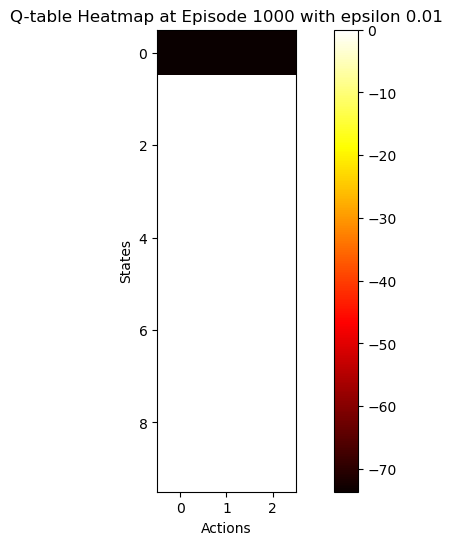

 20%|█▉        | 1994/10000 [00:12<00:35, 225.98it/s]

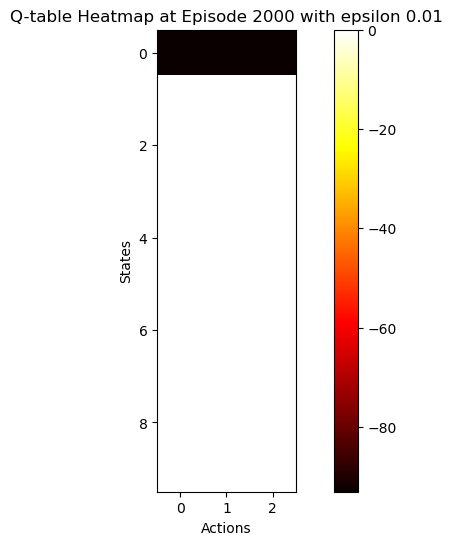

 30%|██▉       | 2993/10000 [00:17<00:32, 218.35it/s]

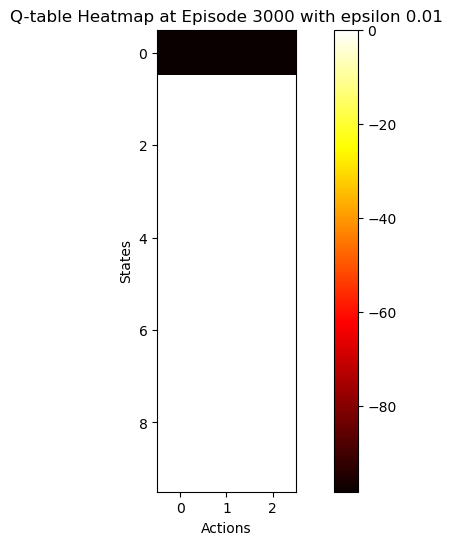

 40%|███▉      | 3978/10000 [00:22<00:27, 216.68it/s]

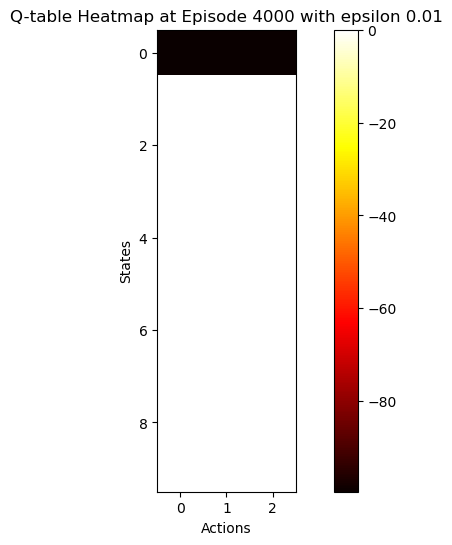

 50%|████▉     | 4978/10000 [00:26<00:22, 220.66it/s]

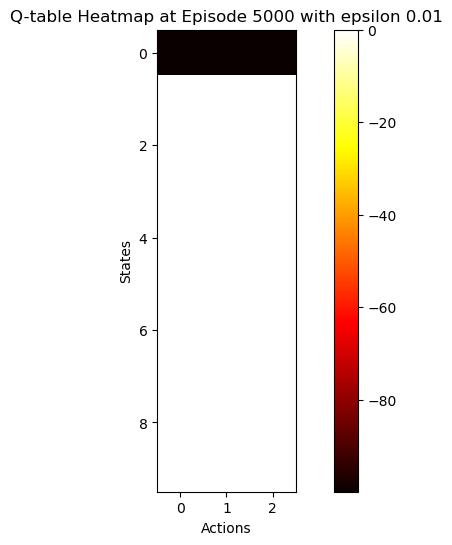

 60%|█████▉    | 5989/10000 [00:31<00:18, 218.32it/s]

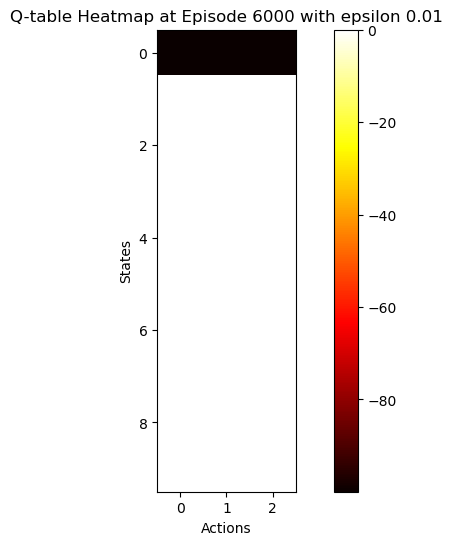

 70%|██████▉   | 6978/10000 [00:36<00:14, 203.29it/s]

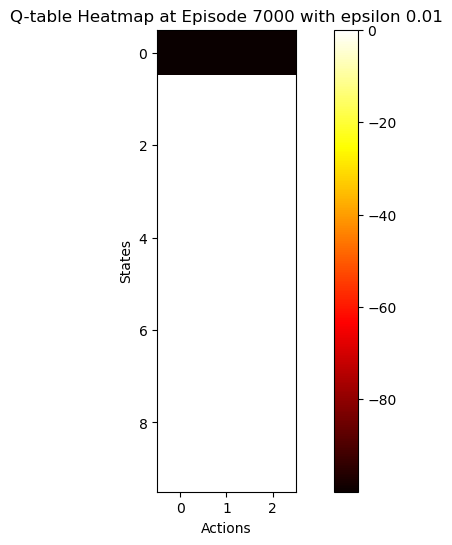

 80%|███████▉  | 7987/10000 [00:40<00:08, 226.36it/s]

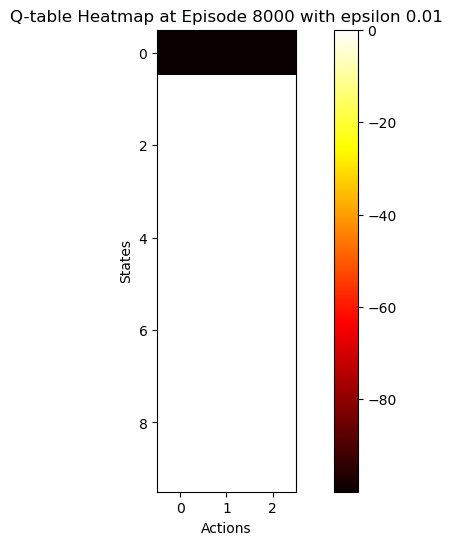

 90%|████████▉ | 8981/10000 [00:45<00:04, 220.08it/s]

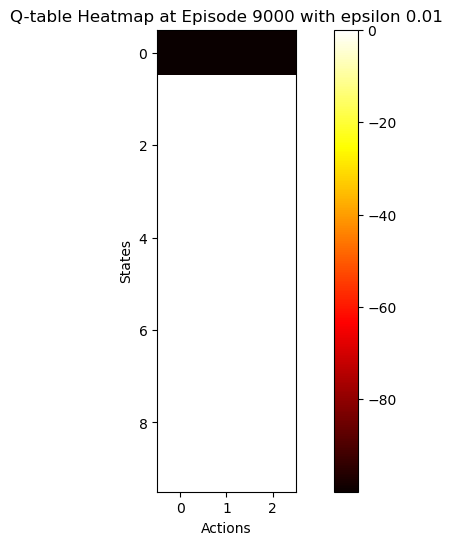

100%|█████████▉| 9977/10000 [00:49<00:00, 231.19it/s]

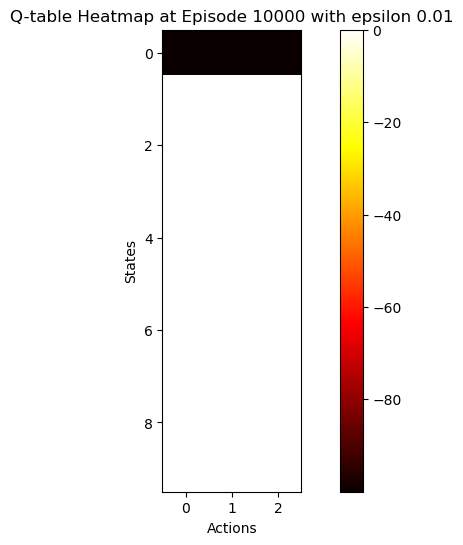

100%|██████████| 10000/10000 [00:52<00:00, 191.27it/s]


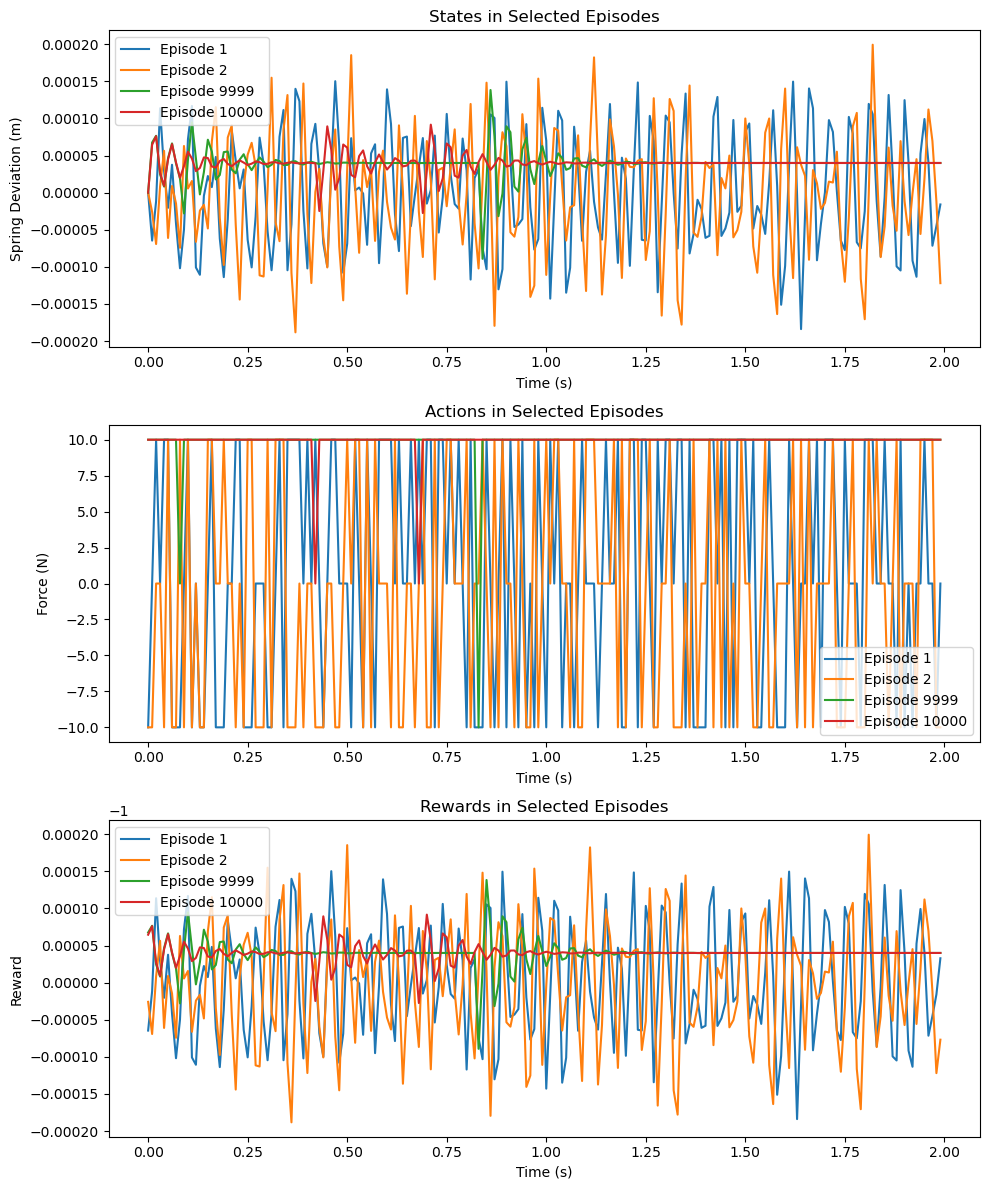

In [9]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import cv2
from tqdm import tqdm
import os

# Constants
EPISODES = 10000
EPISODE_LENGTH = 200
SAMPLE_RATE = 0.01
LEARNING_RATE = 0.002
EPSILON_DECAY = 0.8
MIN_EPSILON = 0.01
GAMMA = 0.99
ACTIONS = [-10, 0, 10]  # Actions in the environment

# Initialize Q-table and epsilon
Q_table = np.zeros((10, len(ACTIONS)))  # 10 states, 3 actions (for simplicity)
EPSILON = 1.0


# Define functions
def choose_action(state):
    """Choose action using epsilon-greedy strategy."""
    if np.random.rand() < EPSILON:
        return np.random.choice(len(ACTIONS))  # Random action
    else:
        return np.argmax(Q_table[state])  # Greedy action

def step_environment(model, data, action, qpos_spring):
    """Step the environment and return next state, reward, done."""
    data.ctrl[0] = action  # Apply force as action
    mujoco.mj_step(model, data)  # Step simulation
    spring_deviation = data.qpos[0] - qpos_spring  # Deviation from equilibrium
    reward = -abs(1/(1+spring_deviation))  # maximize spring compression
    done = False
    return spring_deviation, reward, done

def add_text_to_frame(frame, text, position, font_scale=0.6, color=(0, 0, 0), thickness=2):
    """Helper function to add text to video frames."""
    return cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

def plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live):
    """Plot results."""
    plt.figure(figsize=(10, 12))

    # Plot for state variables
    plt.subplot(3, 1, 1)
    plt.title("States in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Spring Deviation (m)")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("Actions in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, actions_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Force (N)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("Rewards in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, rewards_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Reward")
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    global EPSILON
    task_variable_values = []
    episode_rewards = []
    state_vars = []
    actions_live = []
    rewards_live = []

    # Load model and data
    model_path = os.path.join('..', '..', 'MujocoEnvs', 'springmass.xml')
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)

    # Get the reference equilibrium position for the uncompressed spring
    qpos_spring = model.qpos_spring

    # Initialize rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    renderer = mujoco.Renderer(model)
    camera_name = "cam1"
    requested_episodes = {0, 1, EPISODES - 2, EPISODES - 1}
    video_frames = []

    for episode in tqdm(range(EPISODES)):
        total_rewards_per_step = []  # Store rewards at each step
        data.qpos[0] = qpos_spring  # Start from spring equilibrium
        options = mujoco.MjvOption()
        mujoco.mjv_defaultOption(options)
        episode_state_vars = []
        episode_actions = []
        episode_rewards_timestep = []
        for step in range(EPISODE_LENGTH):
            spring_deviation = data.qpos[0] - qpos_spring
            action_idx = choose_action(int(spring_deviation))  # Use the spring deviation as the state
            action = ACTIONS[action_idx]

            next_spring_deviation, reward, done = step_environment(model, data, action, qpos_spring)
            total_rewards_per_step.append(reward)
            episode_state_vars.append(spring_deviation)
            episode_actions.append(action)
            episode_rewards_timestep.append(reward)

            # Q-learning update
            Q_table[int(spring_deviation), action_idx] += LEARNING_RATE * (reward + GAMMA * np.max(Q_table[int(next_spring_deviation)]) - Q_table[int(spring_deviation), action_idx])

            # Render selected episodes
            if episode in requested_episodes:
                renderer.update_scene(data, camera_name, options)
                pixel = renderer.render()
                frame = cv2.cvtColor(pixel, cv2.COLOR_RGB2BGR)
                frame = add_text_to_frame(frame, f'Episode: {int(episode+1)}', (10, 30))
                frame = add_text_to_frame(frame, f'Time (s): {step * SAMPLE_RATE:.2f}', (10, 60))
                frame = add_text_to_frame(frame, f'Force (N): {action:.2f}', (10, 90))
                video_frames.append(frame)

            if done:
                break

        state_vars.append(episode_state_vars)
        actions_live.append(episode_actions)
        rewards_live.append(episode_rewards_timestep)
        episode_rewards.append(total_rewards_per_step)
        task_variable_values.append(data.qpos[0])  # Store final position of the mass

        # Update epsilon for exploration decay
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

        # Plot Q-table heatmap every 1000 episodes
        if (episode + 1) % 1000 == 0:
            plt.figure(figsize=(10, 6))
            plt.title(f"Q-table Heatmap at Episode {episode + 1} with epsilon {EPSILON:.2f}")
            plt.imshow(Q_table, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()

    # Show the rendered video
    media.show_video(video_frames, fps=100)

    # Plot results for rewards and task variables
    plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live)

if __name__ == "__main__":
    main()


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\4230608101.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.qpos[0] = qpos_spring  # Start from spring equilibrium
C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\4230608101.py:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action_idx = choose_action(int(spring_deviation))  # Use the spring deviation as the state
C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\4230608101.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your

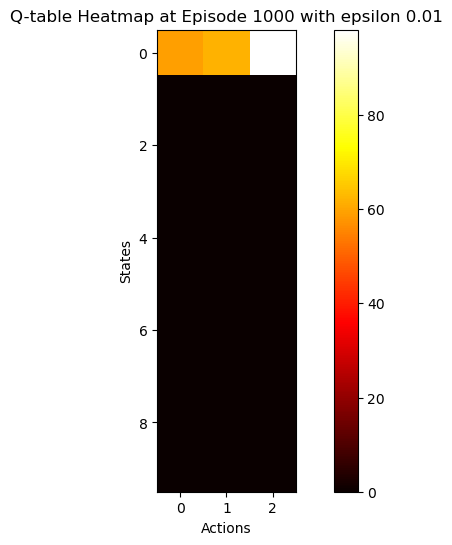

 20%|█▉        | 1984/10000 [00:12<00:35, 224.08it/s]

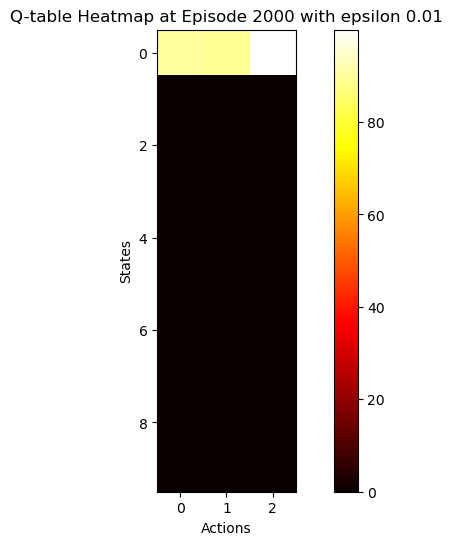

 30%|██▉       | 2989/10000 [00:16<00:29, 240.81it/s]

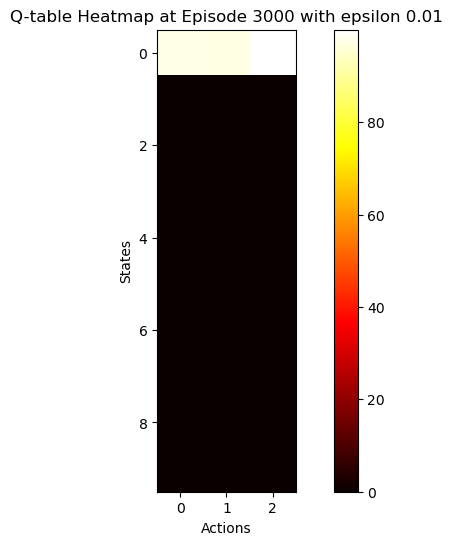

 40%|███▉      | 3983/10000 [00:21<00:26, 226.41it/s]

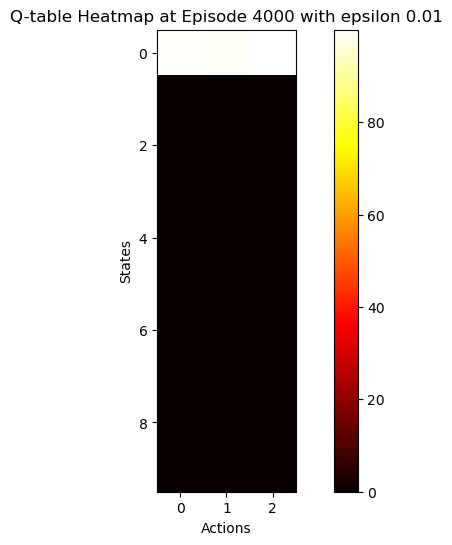

 50%|████▉     | 4995/10000 [00:26<00:21, 228.97it/s]

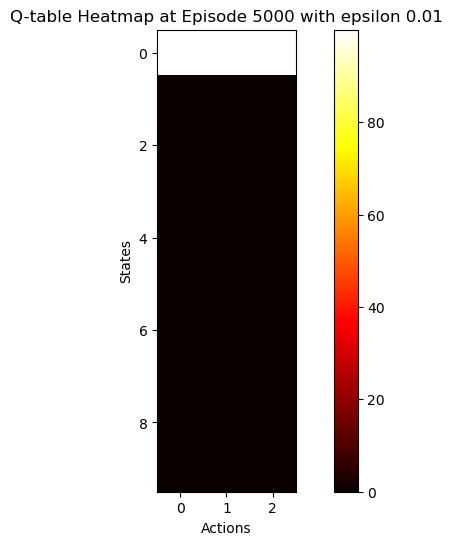

 60%|█████▉    | 5994/10000 [00:30<00:18, 220.95it/s]

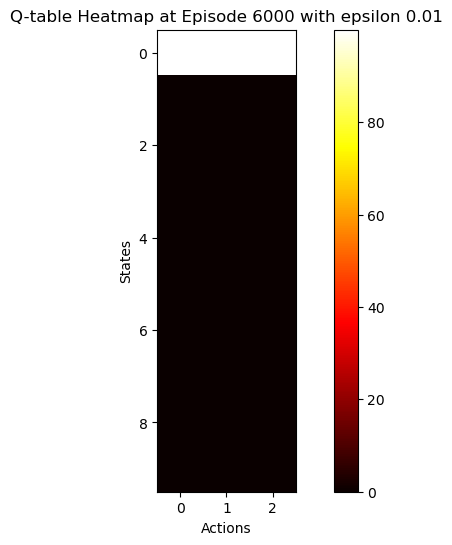

 70%|██████▉   | 6978/10000 [00:35<00:14, 212.49it/s]

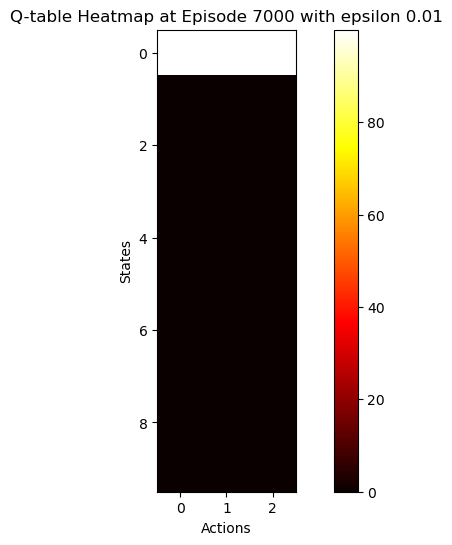

 80%|███████▉  | 7983/10000 [00:39<00:08, 231.96it/s]

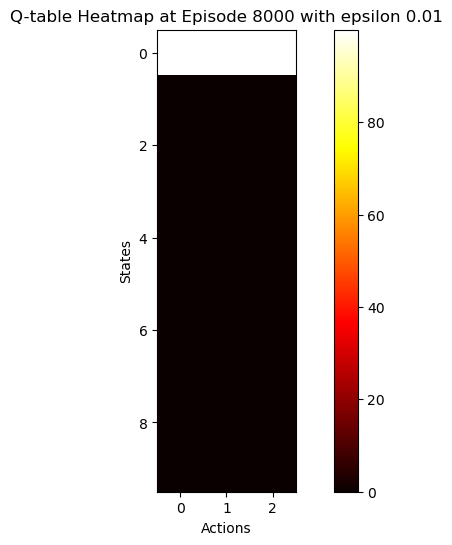

 90%|████████▉ | 8999/10000 [00:44<00:04, 216.83it/s]

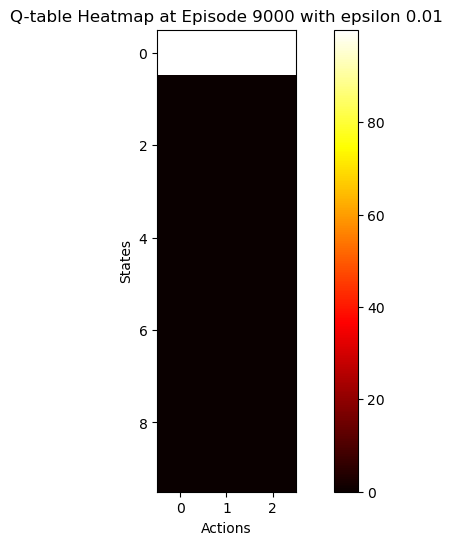

100%|█████████▉| 9991/10000 [00:48<00:00, 195.70it/s]

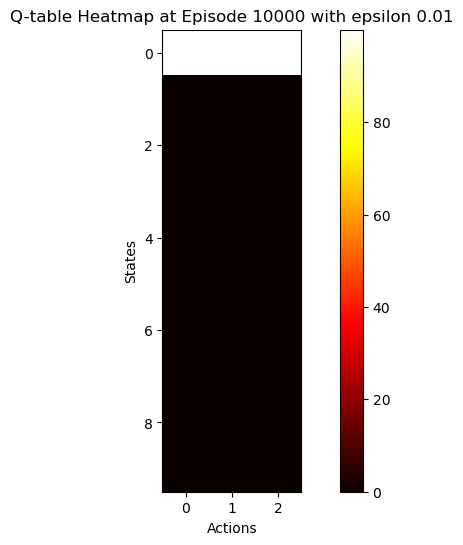

100%|██████████| 10000/10000 [00:50<00:00, 196.18it/s]


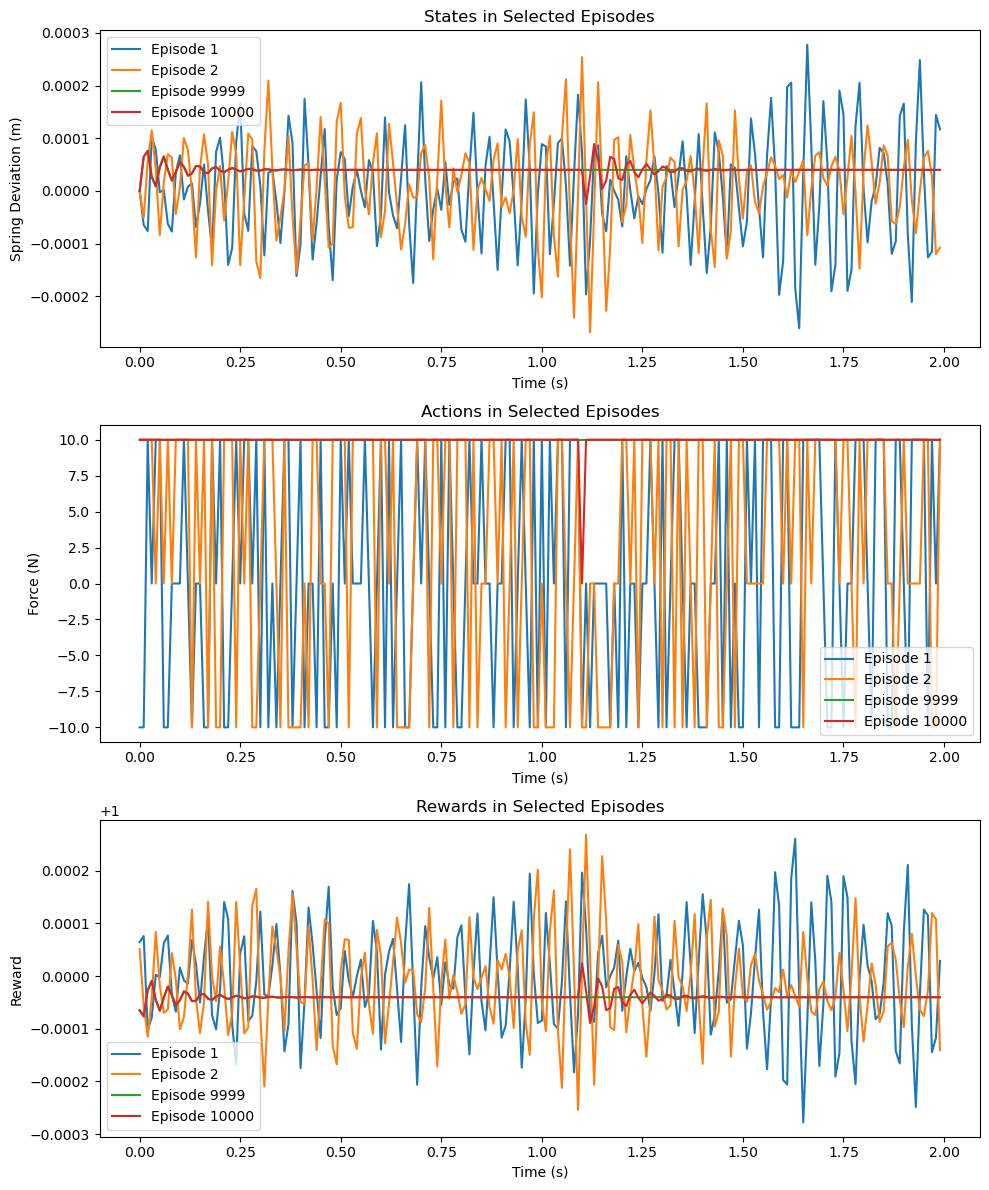

In [10]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import cv2
from tqdm import tqdm
import os

# Constants
EPISODES = 10000
EPISODE_LENGTH = 200
SAMPLE_RATE = 0.01
LEARNING_RATE = 0.002
EPSILON_DECAY = 0.8
MIN_EPSILON = 0.01
GAMMA = 0.99
ACTIONS = [-10, 0, 10]  # Actions in the environment

# Initialize Q-table and epsilon
Q_table = np.zeros((10, len(ACTIONS)))  # 10 states, 3 actions (for simplicity)
EPSILON = 1.0


# Define functions
def choose_action(state):
    """Choose action using epsilon-greedy strategy."""
    if np.random.rand() < EPSILON:
        return np.random.choice(len(ACTIONS))  # Random action
    else:
        return np.argmax(Q_table[state])  # Greedy action

def step_environment(model, data, action, qpos_spring):
    """Step the environment and return next state, reward, done."""
    data.ctrl[0] = action  # Apply force as action
    mujoco.mj_step(model, data)  # Step simulation
    spring_deviation = data.qpos[0] - qpos_spring  # Deviation from equilibrium
    reward = abs(1/(1+(spring_deviation)))  # maximize spring compression
    done = False
    return spring_deviation, reward, done

def add_text_to_frame(frame, text, position, font_scale=0.6, color=(0, 0, 0), thickness=2):
    """Helper function to add text to video frames."""
    return cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

def plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live):
    """Plot results."""
    plt.figure(figsize=(10, 12))

    # Plot for state variables
    plt.subplot(3, 1, 1)
    plt.title("States in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Spring Deviation (m)")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("Actions in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, actions_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Force (N)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("Rewards in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, rewards_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Reward")
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    global EPSILON
    task_variable_values = []
    episode_rewards = []
    state_vars = []
    actions_live = []
    rewards_live = []

    # Load model and data
    model_path = os.path.join('..', '..', 'MujocoEnvs', 'springmass.xml')
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)

    # Get the reference equilibrium position for the uncompressed spring
    qpos_spring = model.qpos_spring

    # Initialize rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    renderer = mujoco.Renderer(model)
    camera_name = "cam1"
    requested_episodes = {0, 1, EPISODES - 2, EPISODES - 1}
    video_frames = []

    for episode in tqdm(range(EPISODES)):
        total_rewards_per_step = []  # Store rewards at each step
        data.qpos[0] = qpos_spring  # Start from spring equilibrium
        options = mujoco.MjvOption()
        mujoco.mjv_defaultOption(options)
        episode_state_vars = []
        episode_actions = []
        episode_rewards_timestep = []
        for step in range(EPISODE_LENGTH):
            spring_deviation = data.qpos[0] - qpos_spring
            action_idx = choose_action(int(spring_deviation))  # Use the spring deviation as the state
            action = ACTIONS[action_idx]

            next_spring_deviation, reward, done = step_environment(model, data, action, qpos_spring)
            total_rewards_per_step.append(reward)
            episode_state_vars.append(spring_deviation)
            episode_actions.append(action)
            episode_rewards_timestep.append(reward)

            # Q-learning update
            Q_table[int(spring_deviation), action_idx] += LEARNING_RATE * (reward + GAMMA * np.max(Q_table[int(next_spring_deviation)]) - Q_table[int(spring_deviation), action_idx])

            # Render selected episodes
            if episode in requested_episodes:
                renderer.update_scene(data, camera_name, options)
                pixel = renderer.render()
                frame = cv2.cvtColor(pixel, cv2.COLOR_RGB2BGR)
                frame = add_text_to_frame(frame, f'Episode: {int(episode+1)}', (10, 30))
                frame = add_text_to_frame(frame, f'Time (s): {step * SAMPLE_RATE:.2f}', (10, 60))
                frame = add_text_to_frame(frame, f'Force (N): {action:.2f}', (10, 90))
                video_frames.append(frame)

            if done:
                break

        state_vars.append(episode_state_vars)
        actions_live.append(episode_actions)
        rewards_live.append(episode_rewards_timestep)
        episode_rewards.append(total_rewards_per_step)
        task_variable_values.append(data.qpos[0])  # Store final position of the mass

        # Update epsilon for exploration decay
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

        # Plot Q-table heatmap every 1000 episodes
        if (episode + 1) % 1000 == 0:
            plt.figure(figsize=(10, 6))
            plt.title(f"Q-table Heatmap at Episode {episode + 1} with epsilon {EPSILON:.2f}")
            plt.imshow(Q_table, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()

    # Show the rendered video
    media.show_video(video_frames, fps=100)

    # Plot results for rewards and task variables
    plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live)

if __name__ == "__main__":
    main()


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\3645693915.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.qpos[0] = qpos_spring  # Start from spring equilibrium
C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\3645693915.py:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action_idx = choose_action(int(spring_deviation))  # Use the spring deviation as the state
C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\3645693915.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your

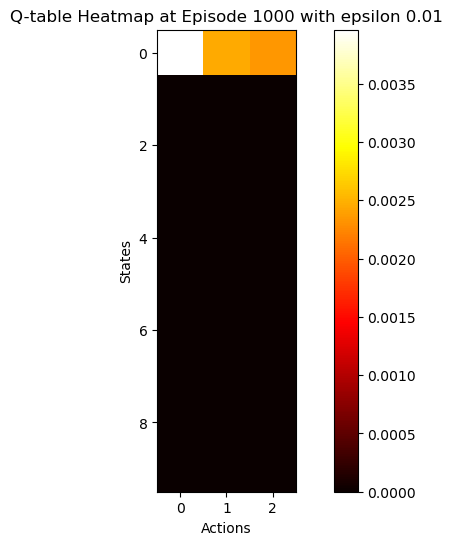

 20%|█▉        | 1977/10000 [00:11<00:31, 257.71it/s]

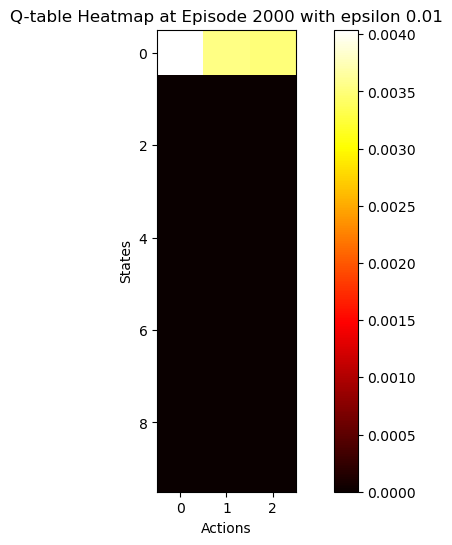

 30%|██▉       | 2988/10000 [00:15<00:28, 248.75it/s]

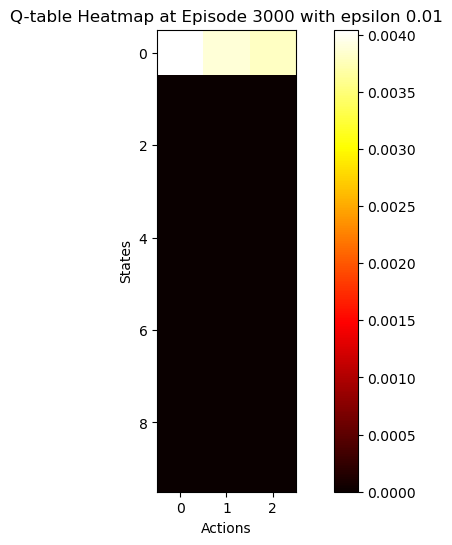

 40%|███▉      | 3978/10000 [00:19<00:23, 255.11it/s]

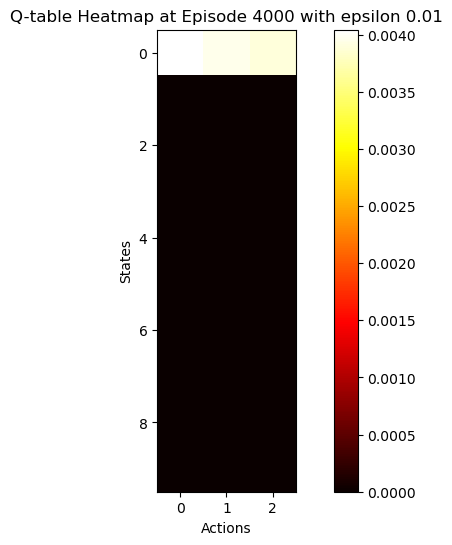

 50%|████▉     | 4988/10000 [00:23<00:18, 265.01it/s]

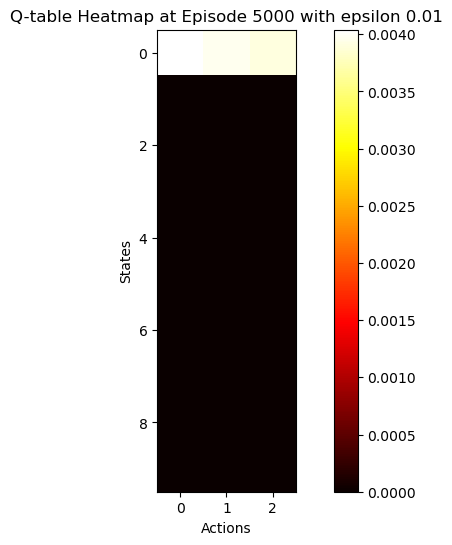

 60%|█████▉    | 5974/10000 [00:27<00:16, 244.11it/s]

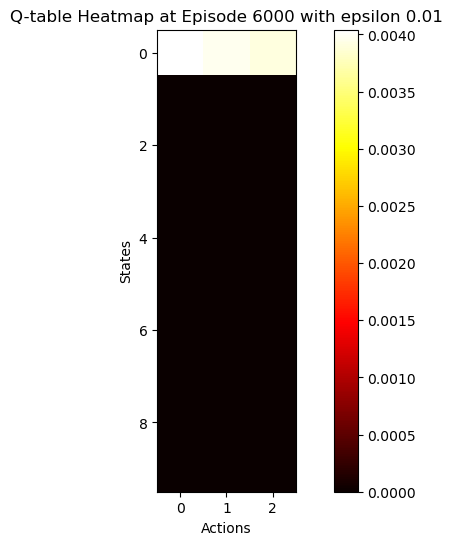

 70%|██████▉   | 6990/10000 [00:31<00:12, 236.49it/s]

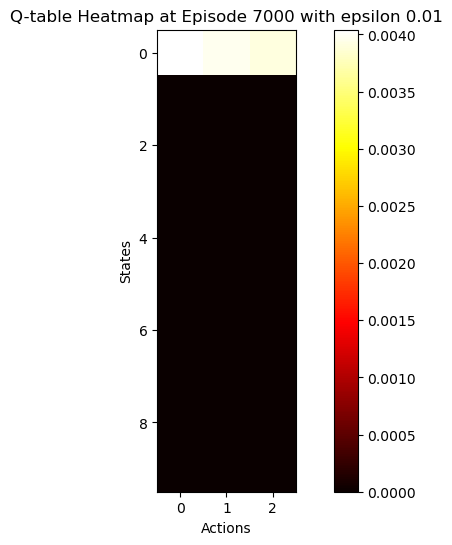

 80%|███████▉  | 7982/10000 [00:35<00:07, 255.83it/s]

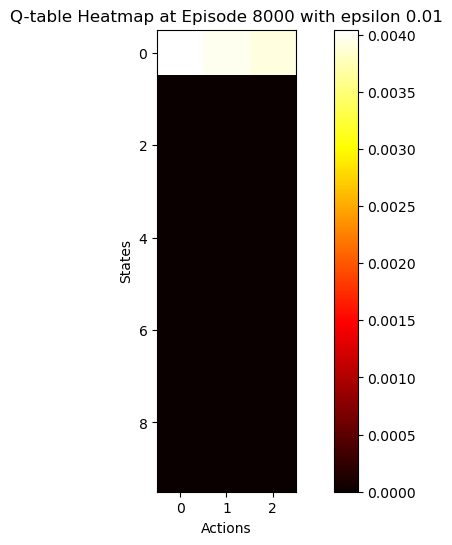

 90%|████████▉ | 8981/10000 [00:39<00:03, 255.46it/s]

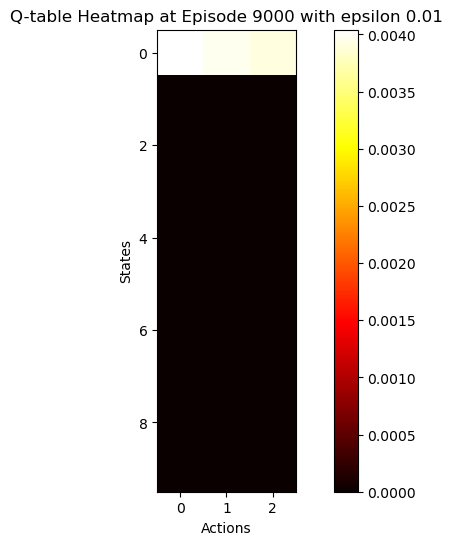

100%|█████████▉| 9989/10000 [00:44<00:00, 243.11it/s]

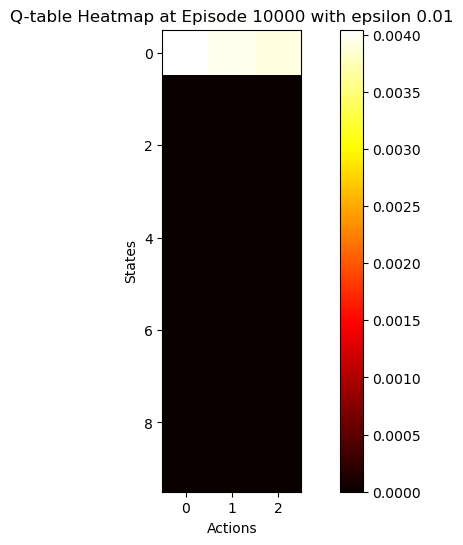

100%|██████████| 10000/10000 [00:46<00:00, 215.75it/s]


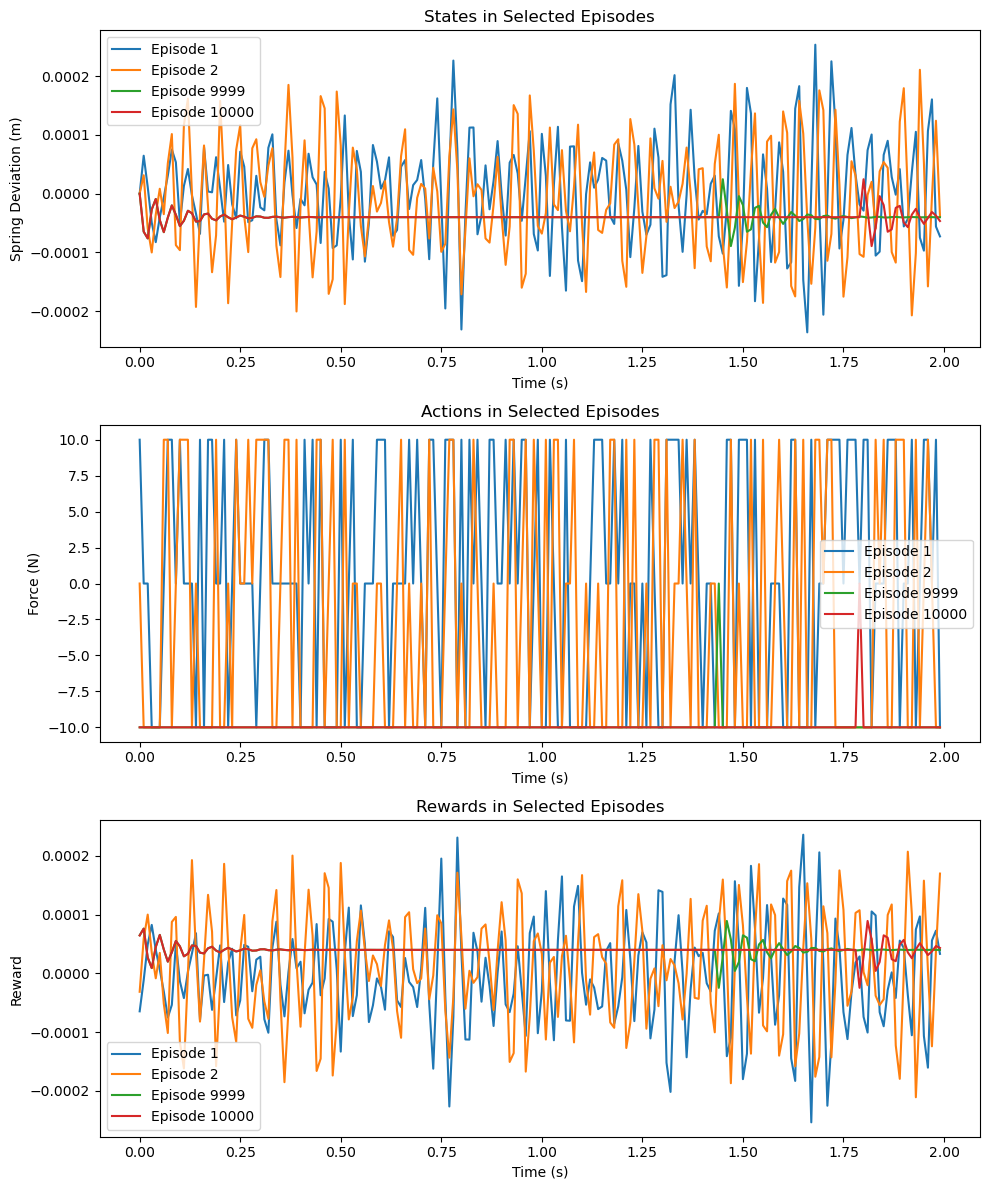

In [11]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import cv2
from tqdm import tqdm
import os

# Constants
EPISODES = 10000
EPISODE_LENGTH = 200
SAMPLE_RATE = 0.01
LEARNING_RATE = 0.002
EPSILON_DECAY = 0.8
MIN_EPSILON = 0.01
GAMMA = 0.99
ACTIONS = [-10, 0, 10]  # Actions in the environment

# Initialize Q-table and epsilon
Q_table = np.zeros((10, len(ACTIONS)))  # 10 states, 3 actions (for simplicity)
EPSILON = 1.0


# Define functions
def choose_action(state):
    """Choose action using epsilon-greedy strategy."""
    if np.random.rand() < EPSILON:
        return np.random.choice(len(ACTIONS))  # Random action
    else:
        return np.argmax(Q_table[state])  # Greedy action

def step_environment(model, data, action, qpos_spring):
    """Step the environment and return next state, reward, done."""
    data.ctrl[0] = action  # Apply force as action
    mujoco.mj_step(model, data)  # Step simulation
    spring_deviation = data.qpos[0] - qpos_spring  # Deviation from equilibrium
    reward = -spring_deviation  # maximize spring compression
    done = False
    return spring_deviation, reward, done

def add_text_to_frame(frame, text, position, font_scale=0.6, color=(0, 0, 0), thickness=2):
    """Helper function to add text to video frames."""
    return cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

def plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live):
    """Plot results."""
    plt.figure(figsize=(10, 12))

    # Plot for state variables
    plt.subplot(3, 1, 1)
    plt.title("States in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Spring Deviation (m)")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("Actions in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, actions_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Force (N)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("Rewards in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, rewards_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Reward")
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    global EPSILON
    task_variable_values = []
    episode_rewards = []
    state_vars = []
    actions_live = []
    rewards_live = []

    # Load model and data
    model_path = os.path.join('..', '..', 'MujocoEnvs', 'springmass.xml')
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)

    # Get the reference equilibrium position for the uncompressed spring
    qpos_spring = model.qpos_spring

    # Initialize rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    renderer = mujoco.Renderer(model)
    camera_name = "cam1"
    requested_episodes = {0, 1, EPISODES - 2, EPISODES - 1}
    video_frames = []

    for episode in tqdm(range(EPISODES)):
        total_rewards_per_step = []  # Store rewards at each step
        data.qpos[0] = qpos_spring  # Start from spring equilibrium
        options = mujoco.MjvOption()
        mujoco.mjv_defaultOption(options)
        episode_state_vars = []
        episode_actions = []
        episode_rewards_timestep = []
        for step in range(EPISODE_LENGTH):
            spring_deviation = data.qpos[0] - qpos_spring
            action_idx = choose_action(int(spring_deviation))  # Use the spring deviation as the state
            action = ACTIONS[action_idx]

            next_spring_deviation, reward, done = step_environment(model, data, action, qpos_spring)
            total_rewards_per_step.append(reward)
            episode_state_vars.append(spring_deviation)
            episode_actions.append(action)
            episode_rewards_timestep.append(reward)

            # Q-learning update
            Q_table[int(spring_deviation), action_idx] += LEARNING_RATE * (reward + GAMMA * np.max(Q_table[int(next_spring_deviation)]) - Q_table[int(spring_deviation), action_idx])

            # Render selected episodes
            if episode in requested_episodes:
                renderer.update_scene(data, camera_name, options)
                pixel = renderer.render()
                frame = cv2.cvtColor(pixel, cv2.COLOR_RGB2BGR)
                frame = add_text_to_frame(frame, f'Episode: {int(episode+1)}', (10, 30))
                frame = add_text_to_frame(frame, f'Time (s): {step * SAMPLE_RATE:.2f}', (10, 60))
                frame = add_text_to_frame(frame, f'Force (N): {action:.2f}', (10, 90))
                video_frames.append(frame)

            if done:
                break

        state_vars.append(episode_state_vars)
        actions_live.append(episode_actions)
        rewards_live.append(episode_rewards_timestep)
        episode_rewards.append(total_rewards_per_step)
        task_variable_values.append(data.qpos[0])  # Store final position of the mass

        # Update epsilon for exploration decay
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

        # Plot Q-table heatmap every 1000 episodes
        if (episode + 1) % 1000 == 0:
            plt.figure(figsize=(10, 6))
            plt.title(f"Q-table Heatmap at Episode {episode + 1} with epsilon {EPSILON:.2f}")
            plt.imshow(Q_table, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()

    # Show the rendered video
    media.show_video(video_frames, fps=100)

    # Plot results for rewards and task variables
    plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live)

if __name__ == "__main__":
    main()


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\827106882.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.qpos[0] = qpos_spring  # Start from spring equilibrium
C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\827106882.py:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action_idx = choose_action(int(spring_deviation))  # Use the spring deviation as the state
C:\Users\rvign\AppData\Local\Temp\ipykernel_30916\827106882.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your ar

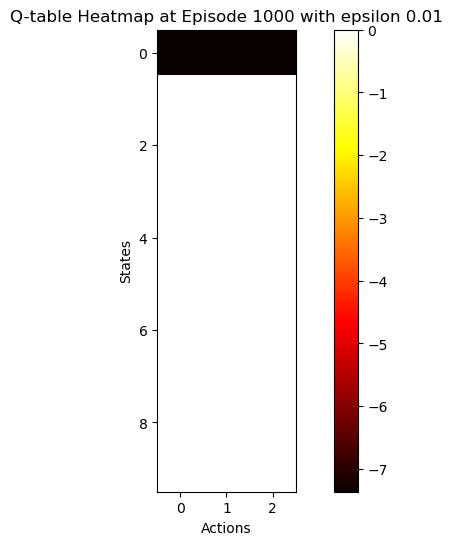

 20%|█▉        | 1993/10000 [00:10<00:31, 255.11it/s]

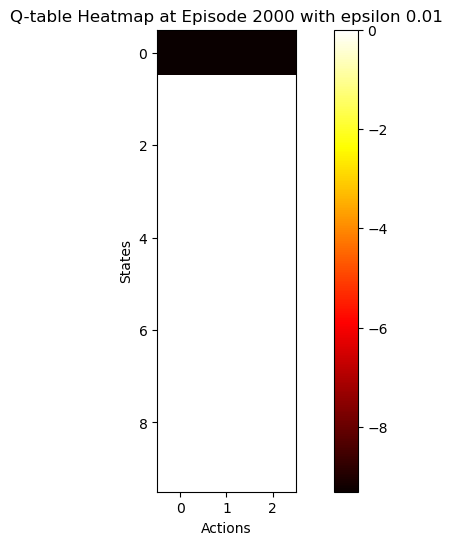

 30%|██▉       | 2980/10000 [00:13<00:22, 308.09it/s]

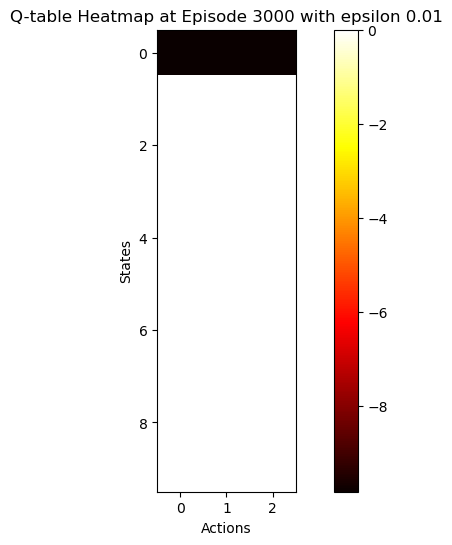

 40%|███▉      | 3996/10000 [00:16<00:18, 324.37it/s]

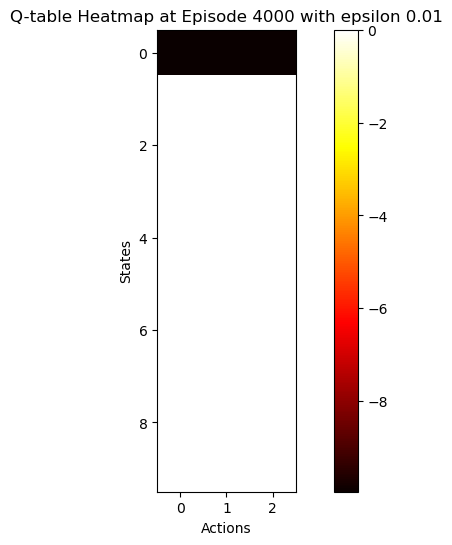

 50%|████▉     | 4978/10000 [00:20<00:15, 317.63it/s]

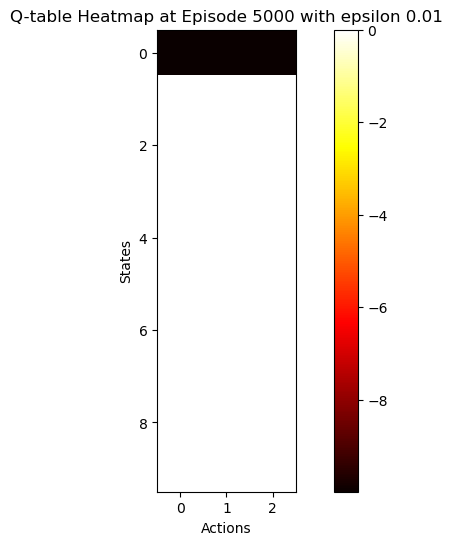

 60%|█████▉    | 5984/10000 [00:23<00:13, 286.87it/s]

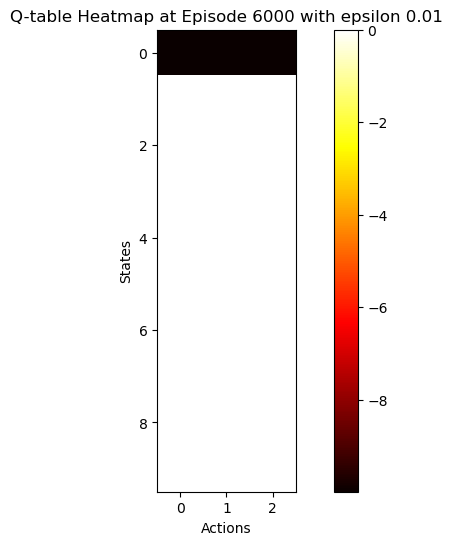

 70%|██████▉   | 6973/10000 [00:26<00:10, 300.50it/s]

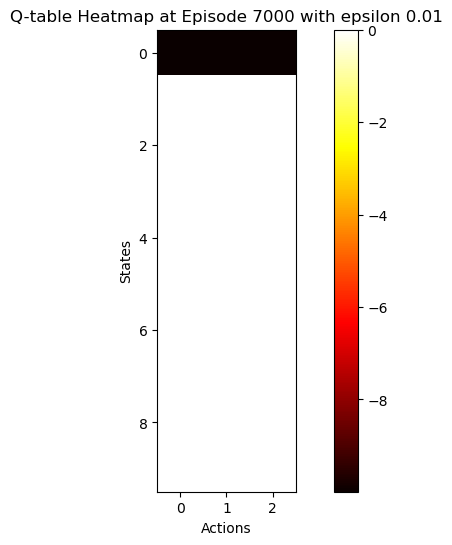

 80%|███████▉  | 7998/10000 [00:30<00:06, 321.23it/s]

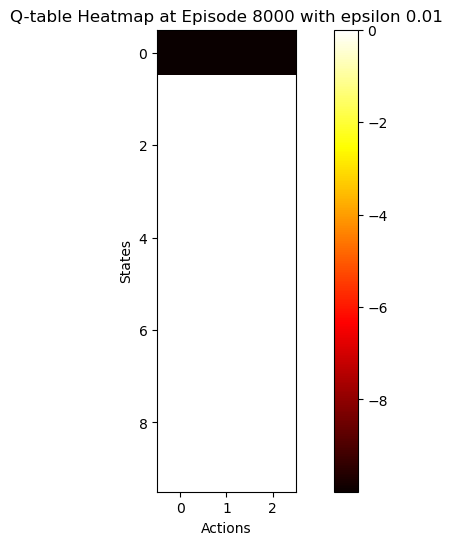

 90%|████████▉ | 8991/10000 [00:33<00:03, 285.51it/s]

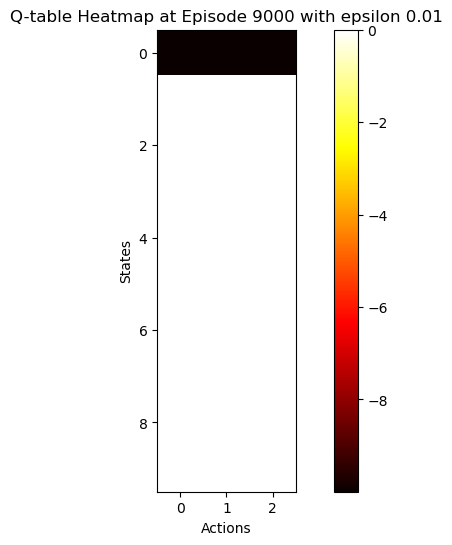

100%|█████████▉| 9993/10000 [00:37<00:00, 321.07it/s]

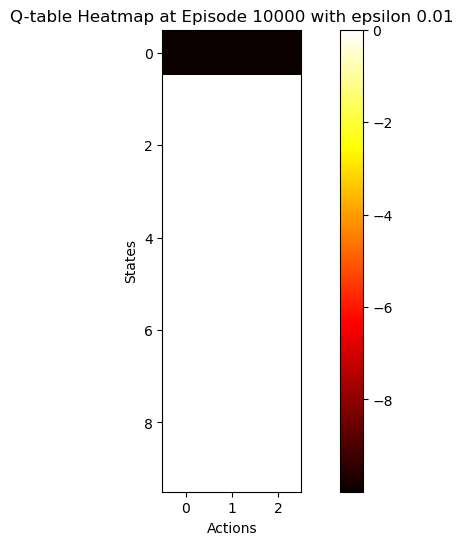

100%|██████████| 10000/10000 [00:39<00:00, 254.04it/s]


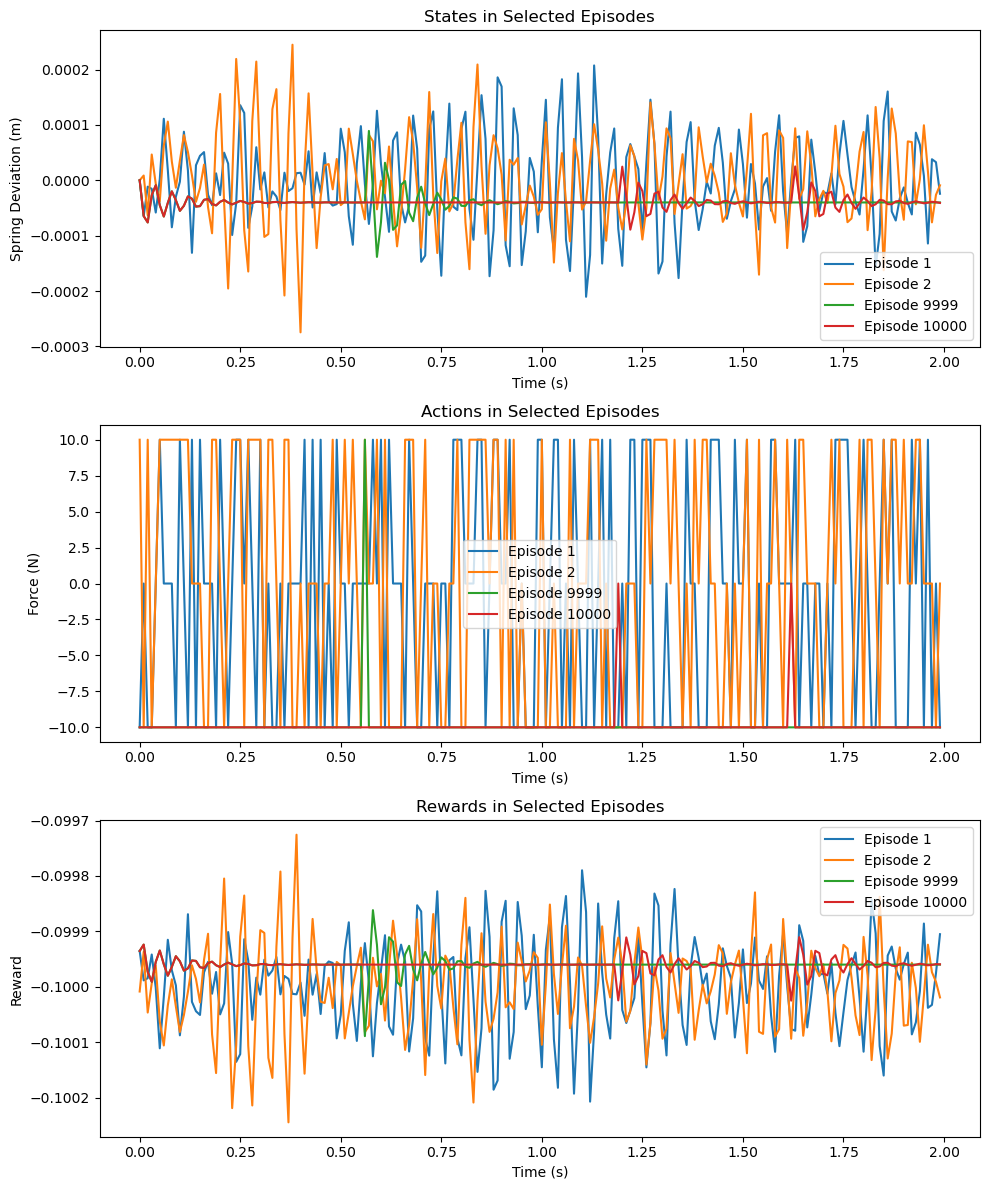

In [12]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import cv2
from tqdm import tqdm
import os

# Constants
EPISODES = 10000
EPISODE_LENGTH = 200
SAMPLE_RATE = 0.01
LEARNING_RATE = 0.002
EPSILON_DECAY = 0.8
MIN_EPSILON = 0.01
GAMMA = 0.99
ACTIONS = [-10, 0, 10]  # Actions in the environment

# Initialize Q-table and epsilon
Q_table = np.zeros((10, len(ACTIONS)))  # 10 states, 3 actions (for simplicity)
EPSILON = 1.0


# Define functions
def choose_action(state):
    """Choose action using epsilon-greedy strategy."""
    if np.random.rand() < EPSILON:
        return np.random.choice(len(ACTIONS))  # Random action
    else:
        return np.argmax(Q_table[state])  # Greedy action

def step_environment(model, data, action, qpos_spring):
    """Step the environment and return next state, reward, done."""
    data.ctrl[0] = action  # Apply force as action
    mujoco.mj_step(model, data)  # Step simulation
    spring_deviation = data.qpos[0] - qpos_spring  # Deviation from equilibrium
    reward = -data.qpos[0]  # maximize spring compression
    done = False
    return spring_deviation, reward, done

def add_text_to_frame(frame, text, position, font_scale=0.6, color=(0, 0, 0), thickness=2):
    """Helper function to add text to video frames."""
    return cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

def plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live):
    """Plot results."""
    plt.figure(figsize=(10, 12))

    # Plot for state variables
    plt.subplot(3, 1, 1)
    plt.title("States in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Spring Deviation (m)")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("Actions in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, actions_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Force (N)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("Rewards in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, rewards_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Reward")
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    global EPSILON
    task_variable_values = []
    episode_rewards = []
    state_vars = []
    actions_live = []
    rewards_live = []

    # Load model and data
    model_path = os.path.join('..', '..', 'MujocoEnvs', 'springmass.xml')
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)

    # Get the reference equilibrium position for the uncompressed spring
    qpos_spring = model.qpos_spring

    # Initialize rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    renderer = mujoco.Renderer(model)
    camera_name = "cam1"
    requested_episodes = {0, 1, EPISODES - 2, EPISODES - 1}
    video_frames = []

    for episode in tqdm(range(EPISODES)):
        total_rewards_per_step = []  # Store rewards at each step
        data.qpos[0] = qpos_spring  # Start from spring equilibrium
        options = mujoco.MjvOption()
        mujoco.mjv_defaultOption(options)
        episode_state_vars = []
        episode_actions = []
        episode_rewards_timestep = []
        for step in range(EPISODE_LENGTH):
            spring_deviation = data.qpos[0] - qpos_spring
            action_idx = choose_action(int(spring_deviation))  # Use the spring deviation as the state
            action = ACTIONS[action_idx]

            next_spring_deviation, reward, done = step_environment(model, data, action, qpos_spring)
            total_rewards_per_step.append(reward)
            episode_state_vars.append(spring_deviation)
            episode_actions.append(action)
            episode_rewards_timestep.append(reward)

            # Q-learning update
            Q_table[int(spring_deviation), action_idx] += LEARNING_RATE * (reward + GAMMA * np.max(Q_table[int(next_spring_deviation)]) - Q_table[int(spring_deviation), action_idx])

            # Render selected episodes
            if episode in requested_episodes:
                renderer.update_scene(data, camera_name, options)
                pixel = renderer.render()
                frame = cv2.cvtColor(pixel, cv2.COLOR_RGB2BGR)
                frame = add_text_to_frame(frame, f'Episode: {int(episode+1)}', (10, 30))
                frame = add_text_to_frame(frame, f'Time (s): {step * SAMPLE_RATE:.2f}', (10, 60))
                frame = add_text_to_frame(frame, f'Force (N): {action:.2f}', (10, 90))
                video_frames.append(frame)

            if done:
                break

        state_vars.append(episode_state_vars)
        actions_live.append(episode_actions)
        rewards_live.append(episode_rewards_timestep)
        episode_rewards.append(total_rewards_per_step)
        task_variable_values.append(data.qpos[0])  # Store final position of the mass

        # Update epsilon for exploration decay
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

        # Plot Q-table heatmap every 1000 episodes
        if (episode + 1) % 1000 == 0:
            plt.figure(figsize=(10, 6))
            plt.title(f"Q-table Heatmap at Episode {episode + 1} with epsilon {EPSILON:.2f}")
            plt.imshow(Q_table, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()

    # Show the rendered video
    media.show_video(video_frames, fps=100)

    # Plot results for rewards and task variables
    plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live)

if __name__ == "__main__":
    main()


In [13]:
import mujoco
import numpy as np
model_path = os.path.join('..', '..', 'MujocoEnvs', 'springmass.xml')
model = mujoco.MjModel.from_xml_path(model_path)
data = mujoco.MjData(model)
print(model.qpos_spring) #For reference position for uncompressed spring

[0.1]


## Spring-mass with ball system
Maximize the ball velocity

In [14]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import cv2
from tqdm import tqdm
import os

# Constants
EPISODES = 10000
EPISODE_LENGTH = 1000
SAMPLE_RATE = 0.01
LEARNING_RATE = 0.002
EPSILON_DECAY = 0.8
MIN_EPSILON = 0.01
GAMMA = 0.99
ACTIONS = [-20, 0, 20]  # Force limits for ball movement along x-axis

# Initialize Q-table and epsilon
Q_table = np.zeros((2, len(ACTIONS)))  #2 states, 3 actions
EPSILON = 1.0


def choose_action(state):
    """Choose action using epsilon-greedy strategy."""
    if np.random.rand() < EPSILON:
        return np.random.choice(len(ACTIONS))  # Random action
    else:
        return np.argmax(Q_table[state])  # Greedy action

def step_environment(model, data, action):
    """Step the environment and return next state, reward, done."""
    data.ctrl[0] = action  # Apply force to the ball along x-axis
    mujoco.mj_step(model, data)  # Step simulation

    # Discretize the ball's x-velocity as state
    next_state = data.qpos[1], data.qvel[1]  # position,velocity

    # Reward is proportional to the positive velocity of the ball along x-axis
    reward = data.qvel[1]  # Maximize velocity along x-axis

    # Check if the ball hits the wall or goes out of range
    done = data.qpos[1] >= 2.0 or data.qpos[1] <= -10.0
    return next_state, reward, done

def add_text_to_frame(frame, text, position, font_scale=0.6, color=(0, 0, 0), thickness=2):
    """Helper function to add text to video frames."""
    return cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

def plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live):
    """Plot results."""
    plt.figure(figsize=(10, 12))

    # Plot for state variables
    plt.subplot(4, 1, 1)
    plt.title("States in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode][0], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("ball position (m/s)")
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.title("States in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode][1], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("ball velocity (m/s)")
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.title("Actions in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, actions_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("force (N)")
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.title("Rewards in Selected Episodes")
    for episode in [0, 1, EPISODES - 2, EPISODES - 1]:
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, rewards_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Reward points")
    plt.legend()

    plt.figure(figsize=(10, 5))
    # Plot for cumulative rewards
    plt.subplot(2, 1, 1)
    plt.title("Cumulative Rewards vs Episode Count")
    cumulative_rewards = [sum(episode) for episode in episode_rewards]
    plt.plot(range(len(cumulative_rewards)), cumulative_rewards)
    plt.xlabel("Episode Count")
    plt.ylabel("Cumulative Reward")

    # Plot for task variable values
    plt.subplot(2, 1, 2)
    plt.title("Task Variable Value vs Episode Count")
    plt.plot(range(len(task_variable_values)), task_variable_values)
    plt.xlabel("Episode Count")
    plt.ylabel("Final x-velocity (m/s)")

    plt.tight_layout()
    plt.show()

def main():
    global EPSILON
    task_variable_values = []
    episode_rewards = []
    state_vars = []
    actions_live = []
    rewards_live = []

    # Load model and data
    model_path = os.path.join('..', '..', 'MujocoEnvs', 'springball.xml')
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)

    # Initialize rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    renderer = mujoco.Renderer(model)
    # Rendering setup
    camera_name = "cam1"
    # Define the episodes to render
    requested_episodes = {0, 1, EPISODES - 2, EPISODES - 1}
    video_frames = []

    for episode in tqdm(range(EPISODES)):
        total_rewards_per_step = []  # Store rewards at each step
        # Reset environment
        data.qpos[1] = 0.0  # Reset ball position
        episode_state_vars = []
        episode_actions = []
        episode_rewards_timestep = []
        
        for step in range(EPISODE_LENGTH):
            state = data.qpos[1], data.qvel[1]  # position, velocity
            action_idx = choose_action(state)
            action = ACTIONS[action_idx]

            next_state, reward, done = step_environment(model, data, action)
            total_rewards_per_step.append(reward)
            episode_state_vars.append(state)
            episode_actions.append(action)
            episode_rewards_timestep.append(reward)
            # Q-learning update
            Q_table[state, action_idx] += LEARNING_RATE * (reward + GAMMA * np.max(Q_table[next_state]) - Q_table[state, action_idx])

            # Render selected episodes
            if episode in requested_episodes:
                renderer.update_scene(data, camera_name, options)
                pixel = renderer.render()
                frame = cv2.cvtColor(pixel, cv2.COLOR_RGB2BGR)
                frame = add_text_to_frame(frame, f'Episode: {int(episode + 1)}', (10, 30))
                frame = add_text_to_frame(frame, f'Time (s): {step * SAMPLE_RATE:.2f}', (10, 60))
                frame = add_text_to_frame(frame, f'Force (N): {action:.2f}', (10, 90))
                video_frames.append(frame)

            if done:
                break

        state_vars.append(episode_state_vars)
        actions_live.append(episode_actions)
        rewards_live.append(episode_rewards_timestep)
        episode_rewards.append(total_rewards_per_step)
        task_variable_values.append(data.qvel[1])  # Store final velocity of the ball

        # Update epsilon for exploration decay
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

        # Plot Q-table heatmap every 1000 episodes
        if (episode + 1) % 1000 == 0:
            plt.figure(figsize=(10, 6))
            plt.title(f"Q-table Heatmap at Episode {episode + 1} with epsilon {EPSILON:.2f}")
            plt.imshow(Q_table, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()

    # Show the rendered video
    media.show_video(video_frames, fps=100)

    # Plot results for rewards and task variables
    plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live)

if __name__ == "__main__":
    main()


  0%|          | 0/10000 [00:00<?, ?it/s]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices